# 데이터 사이언스 책 추천

### LDA 기반의 도서 추천 모델 제작

- 경험 : 실제 교보 문고에 직접 가서 보게 되면 데이터 사이언스 관련 책이 너무 많고, 실제로 분류도 적절하게 되지 않은 것을 확인할 수 있음
    - 예 : 파이썬, 인공지능, 데이터사이언스, 시각화 등등 다 같은 분야의 책인데 섞여서 존재함
    - NLP 관련책이 파이썬에 있을 수도, 인공지능에 있을 수도 있기에 직접 찾기가 어렵다
- 또한, 원서의 경우 선택하기에 어려움이 존재
- 위와 같은 점을 고려하였을 때, 사용자가 원하는 수준의 책을 얻는 것이 어렵다
- 또한 인터넷에 있는 자료들의 경우 너무 오래된 경우가 많음
- 이러한 점을 고려하여 LDA 기반의 content-based filtering을 활용한 도서 추천 모델을 활용하여 사용자의 context와 고려하여 가장 적절한 책을 추천을 통하여 이러한 점을 해소할 수 있다.
- 또한 주기적인 데이터 수집 및 최신화를 통해서 최신의 서적에 대해서도 추천을 받을 수 있다.

#### 추천 시스템 관련 문제

- content-based filtering 방법을 사용하기 때문에 cold-start 문제에는 적절하게 대응할 수 있다.
- 하지만 collaborative filtering에 비해서는 개인화 맞춤이 약간은 떨어질 수 있다.
    - 위의 부분을 해소하기 위해 추후 방법 생각

## 번역
### 원서의 경우 영문 그대로를 사용하는 것이 아닌 Deepl API를 활용하여 한글로 번역을 한 후 사용

In [ ]:
def translate(raw_text):
    api_key = "b14dfe91-4e6b-1864-840b-4c64eb6149e8"
    translator = deepl.Translator(api_key)
    result = translator.translate_text(raw_text, target_lang="KO")

    return result

eng_book = pd.read_csv("./eng_book.csv")

# 너무 길이가 길어서 request오류를 위해 20000자가 넘는 경우 제거
lengths = eng_book["index"].apply(lambda x: len(x))
long_texts_indices = lengths[lengths > 20000].index
eng_book = eng_book.drop(long_texts_indices)

eng_book["translate_title"] = eng_book["상품명"].apply(translate)
eng_book["translate_index"] = eng_book["index"].apply(translate)
eng_book["translate_book_info"] = eng_book["book_info"].apply(translate)
eng_book["translate_author"] = eng_book["author_info"].apply(translate)

eng_book.to_csv("translate.csv", index=False)

### EDA

In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import koreanize_matplotlib

In [2]:
from konlpy.tag import Okt, Kkma, Hannanum, Komoran

In [3]:
df = pd.read_csv("./data/merge_data_review.csv")
df_temp = df[['분야','title','index','book_info','author_info','review_text']]
df_temp

분야                                     title  \
0        과학                기계의 반칙 | 넬로 크리스티아니니 - 교보문고   
1    컴퓨터/IT       머신 러닝 교과서: 파이토치 편 | 세바스찬 라시카 - 교보문고   
2    컴퓨터/IT      기초에서 응용까지 대화형 GPT: 생성AI | 강건욱 - 교보문고   
3     정치/사회                    인공지능X메타버스 | 홍성태 - 교보문고   
4    컴퓨터/IT            파이썬 인공지능 자율주행 자동차 | 서민우 - 교보문고   
..      ...                                       ...   
491  컴퓨터/IT                딥러닝 일러스트레이티드 | 존 크론 - 교보문고   
492  컴퓨터/IT  자산운용을 위한 금융 머신러닝 | 마르코스 로페즈 데 프라도 - 교보문고   
493  컴퓨터/IT                인공지능을 위한 기초수학 | 이규봉 - 교보문고   
494      과학           누가 인공지능을 두려워하나? | 토마스 람게 - 교보문고   
495  컴퓨터/IT                 인공지능 교과서 | 이모토 타카시 - 교보문고   

                                                 index  \
0    1장. 지능의 탐구기대치 관리 지능 정의 규칙에 따르는 세계생존 기법의 깜짝주머니외...   
1    1장. 컴퓨터는 데이터에서 배운다1.1 데이터를 지식으로 바꾸는 지능적인 시스템 구...   
2    제1부 인공지능1. 개요1.1 인공지능(AI, Artificial Intellige...   
3    머리말1부    인공지능의 사회적 이해1부    - 멋진 신세계 - 여는 글1장  ...   
4    Chapter 01 인공지능 자율주행 자동차 체험하기01 자율주행 자동차의 이해 0...   
..                                                 ...   
491  제1부 소개제1장 생물의 눈과 기계의 눈제2장 사람의 언어와 기계의 언어제3장 기계...   
492  1장. 들어가며 1.1 동기 부여 1.2 이론이 중요하다 1.2.1 교훈1: 이론이...   
493  1. 옥타브 사용하기2. 선형대수3. 함수와 수열4. 미분5. 확률과 통계6. 최소...   
494  서론 불가능이 가능해지는 순간: 모든 것이 갑자기 변하기 시작한다 \t71장스스로 ...   
495  제1장 【기초편】 인공지능(AI)의 세계 1.1 인공지능이란 무엇인가  인공지능의 ...   

                                             book_info  \
0    25년 이상 인공지능 연구에 기여한 최고의 석학이 집필한 IT 과학교양서다. 현대 ...   
1    아마존 베스트셀러인 『머신 러닝 교과서』가 파이토치 편으로 새롭게 태어났다! 머신 ...   
2    2023년 대화형 GPT의 등장으로, 인간과 AI의 협업과 공존의 혁신적인 시대가 ...   
3    인공지능이 본격화된 정보사회의 새로운 국면에서 초래되는 사회문화적 쟁점들을 소개한 ...   
4    이 책의 각 단원의 핵심 내용은 다음과 같다. 1장에서는 파이썬과 텐서플로 기반 인...   
..                                                 ...   
491                     ☞ 선정 및 수상내역- 2021 세종서적 학술부문 선정   
492  로페즈 데 프라도 박사의 저서 『실전 금융 머신러닝 완벽 분석』의 후속작으로, 개념...   
493  『인공지능을 위한 기초수학』은 〈옥타브 사용하기〉, 〈선형대수〉, 〈함수와 수열〉,...   
494  한때는 공상과학 속 상상이라 여겼던 일들이 일상이 되고, 모든 것이 갑자기 변하고 ...   
495  『인공지능 교과서』는 〈인공지능이란 무엇인가〉, 〈인공지능의 가치〉, 〈인공지능은 ...   

                                           author_info  \
0    ['(Nello Cristianini)머신러닝 및 인공지능 분야에 20년 이상 종사...   
1    ['Sebastian Raschka위스콘신-매디슨 대학교의 통계학 조교수로 머신 러...   
2    ['AI는 지능적인 기능을 개발하고 사회적, 경제적 영향력을 키우는 중요한 기술로 ...   
3    ['원주의 상지대학교 문화콘텐츠학과 교수로 재직하고 있으며, 정보, 생태, 건축-도...   
4    ['현) 코코랩스(http://www.kocolabs.co.kr/) 대표연세대학교 ...   
..                                                 ...   
491  ['머신러닝 회사 언탭트의 수석 데이터 과학자입니다. 애디슨-웨슬리에서 출간한 여러...   
492  ['Marcos M. Lopez de Prado 코넬대학 공과대학교 교수, 트루 포...   
493  ['\n                아래의 알림 신청 시 원하시는 소식을 받아 보실...   
494  ['Thomas Ramge독일의 경제 전문지 《브란트아인스brand eins》의 기...   
495  ['대학에서 컴퓨터공학을 전문으로 공부했다. 이후 광선로 계측 관련 회사에서 유저 ...   

                                           review_text  
0                                                  NaN  
1                                                  NaN  
2                                                  NaN  
3                                                  NaN  
4                                                  NaN  
..                                                 ...  
491  \n딥러닝의 개요를 예쁜 그림과 함께 재미있게 잘 전달해 주네요\n인공신경망부터 G...  
492  \n근데 번역이 너무 성의가 없어요.구글 번역기 돌린 것처럼 번역투가 너무 심해서 ...  
493                                                NaN  
494  \n   누가 인공지능을 두려워하나?     토마스 람게/ 다섯수레      나는 ...  
495                                                NaN  

[496 rows x 6 columns]

In [10]:
import koreanize_matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams['font.family'] ='Malgun Gothic'

### 텍스트 마이닝(책정보/목차/작가정보/리뷰텍스트)

In [5]:
import seaborn as sns

In [8]:
sns.set_theme(style="ticks")

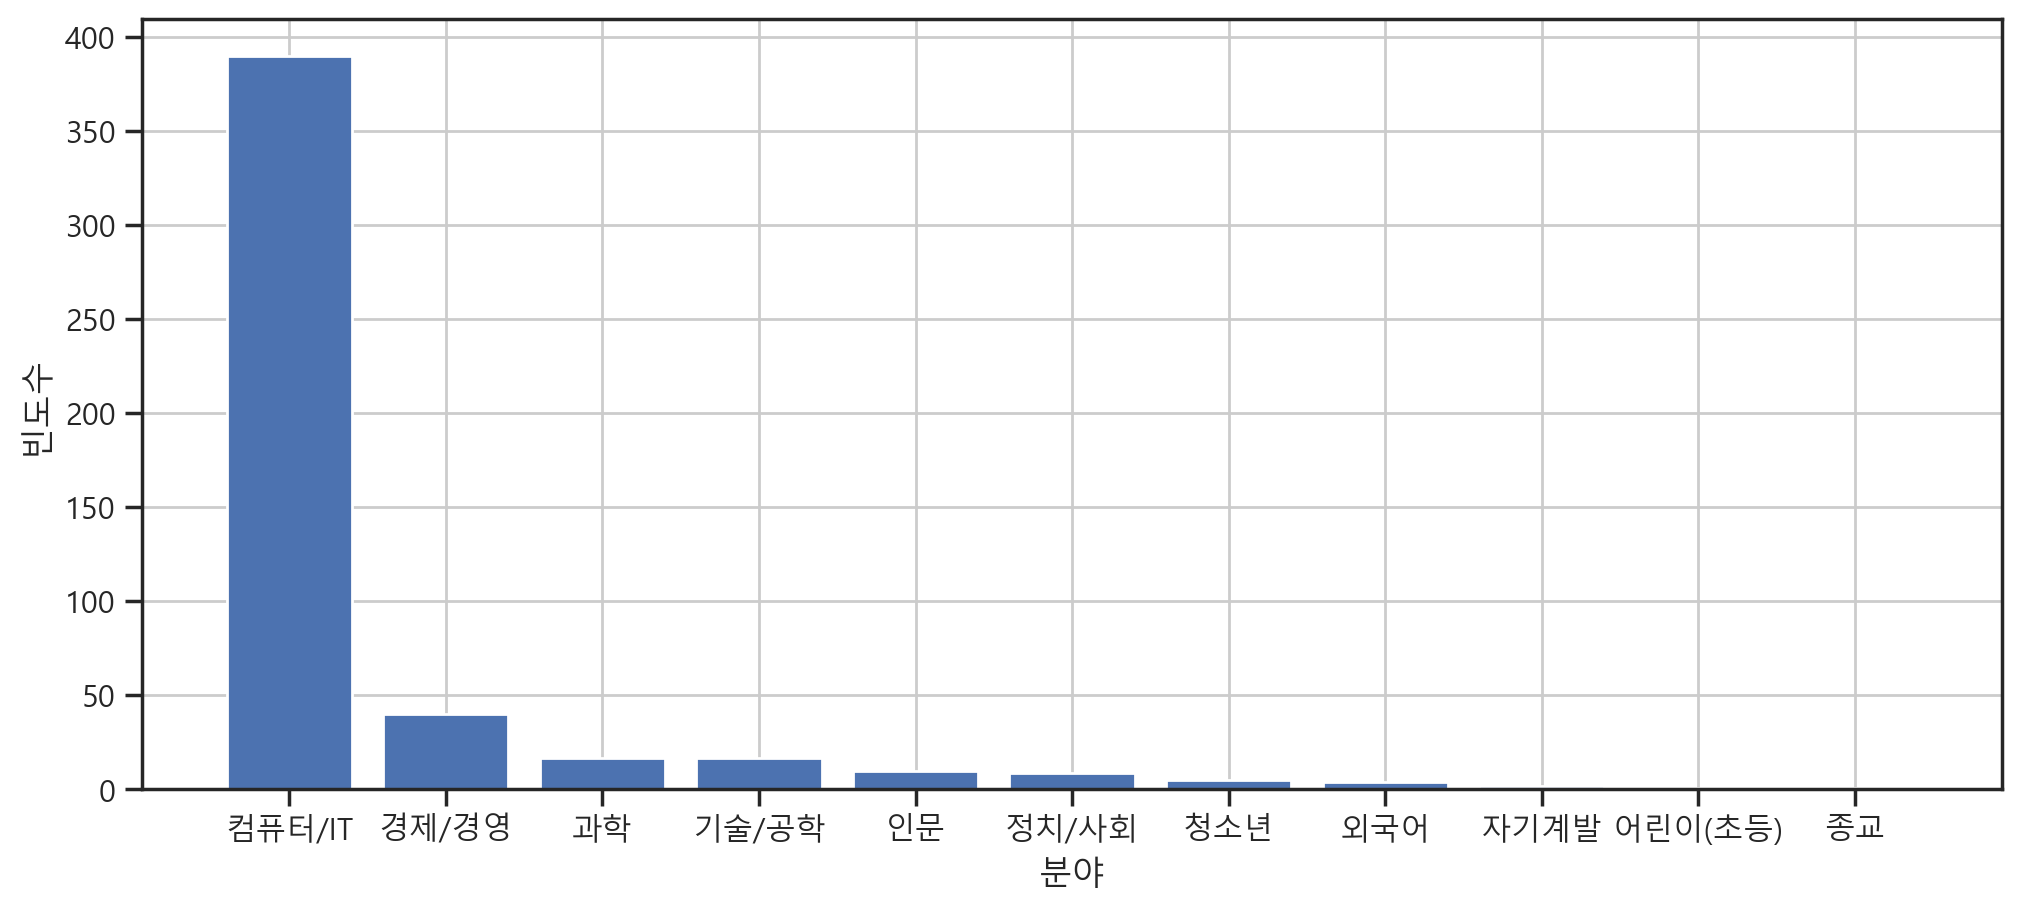

In [13]:
plt.figure(figsize=(12,5))
plt.xlabel('분야')
plt.ylabel('빈도수')
plt.grid(True)
plt.bar(df_temp['분야'].value_counts().index, df_temp['분야'].value_counts(), align='center')
plt.show()

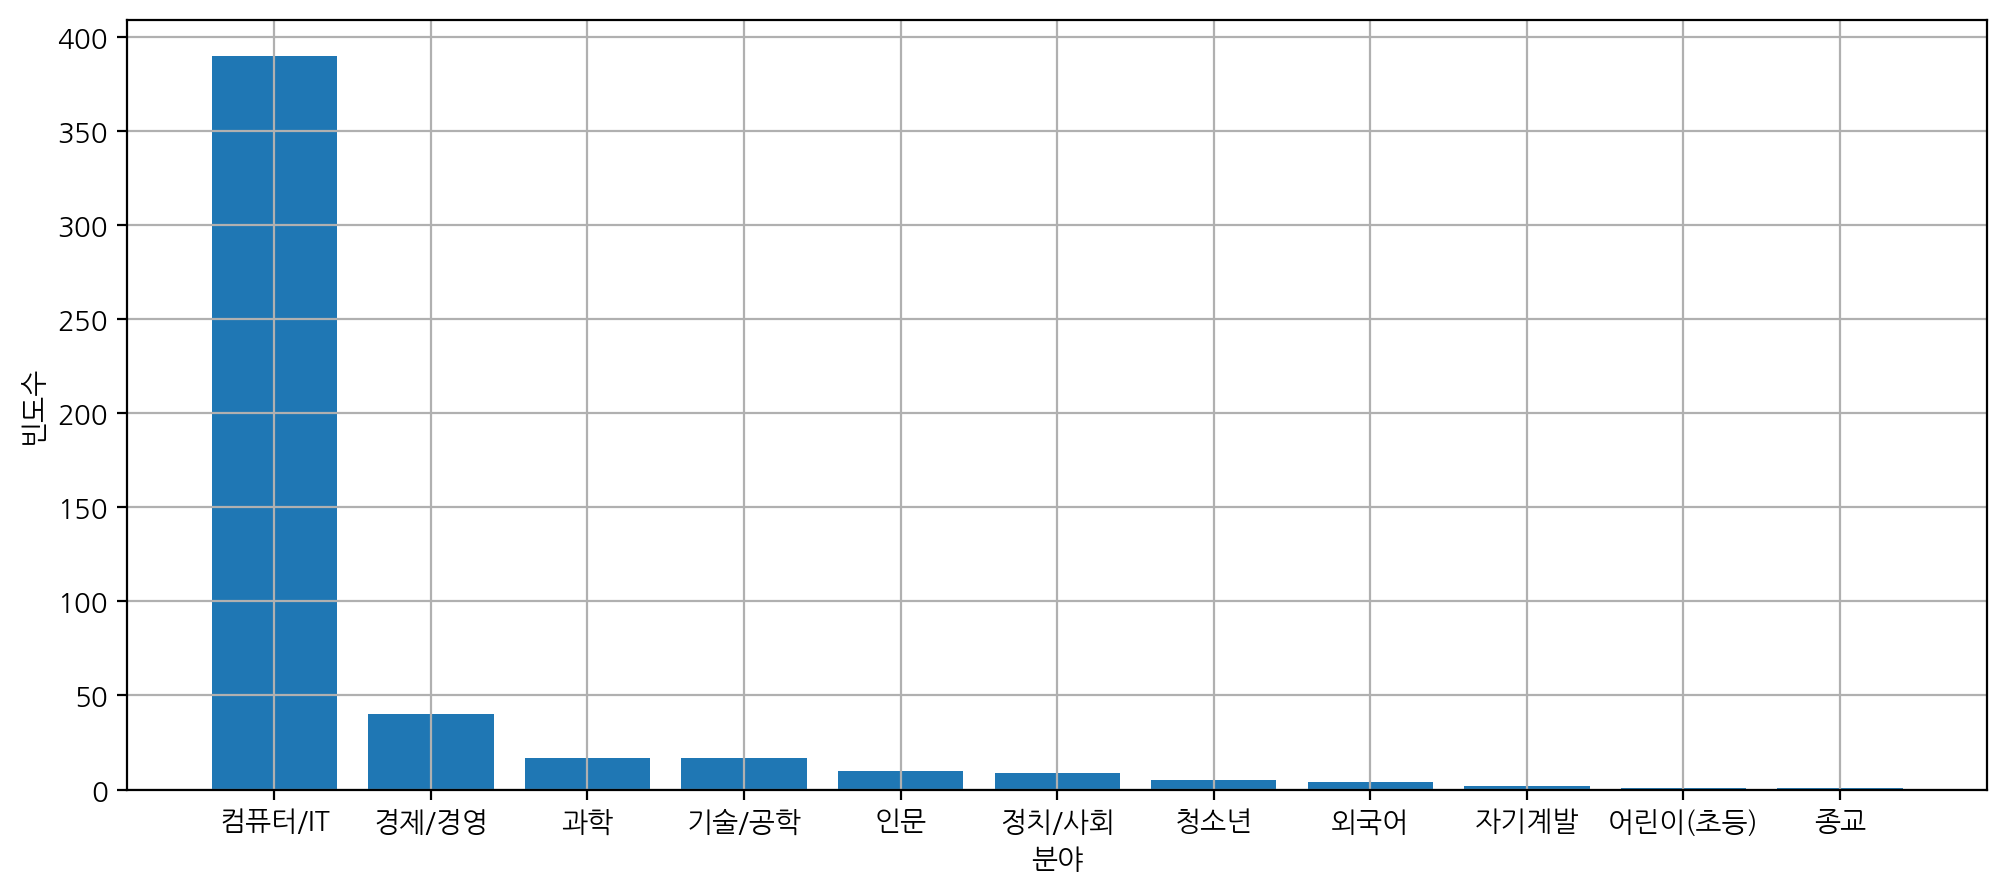

In [105]:
plt.figure(figsize=(12,5))
plt.xlabel('분야')
plt.ylabel('빈도수')
plt.grid(True)
plt.bar(df_temp['분야'].value_counts().index, df_temp['분야'].value_counts(), align='center')
plt.show()

In [21]:
def word(df_word,col):

    msg = ''
    for i in range(len(df_word)):
        val = df_word[col].iloc[i]
        if not isinstance(val, str):
            continue
        msg = msg + re.sub(r'[^\w]', ' ', val) + ' '

    nlp=Okt()
    
    msg_n = nlp.nouns(msg)
    count = Counter(msg_n)

    word_count=dict()
    for tag, counts in count.most_common(100):
        if len(str(tag))>1:
            word_count[tag] = counts
            
    word_count.pop('인공', None)
    word_count.pop('지능', None)
    word_count.pop('인공지능', None)
    word_count.pop('머신', None)
    word_count.pop('러닝', None)
    word_count.pop('머신러닝', None)
    word_count.pop('교보문고', None)
    word_count.pop('교보', None)
    word_count.pop('문고', None)
    
   # hist(word_count)
    wdCloud(word_count)

In [22]:
def hist(word_count):

    plt.figure(figsize=(15,8))
    plt.xlabel('키워드')
    plt.ylabel('빈도수')
    plt.grid(True)
    sorted_keys=sorted(word_count, key=word_count.get, reverse=True)
    sorted_values=sorted(word_count.values(), reverse=True)
    plt.bar(range(len(word_count)), sorted_values, align='center')
    plt.xticks(range(len(word_count)), list(sorted_keys), rotation=75)
    plt.show()

In [15]:
from PIL import Image

In [18]:
import numpy as np

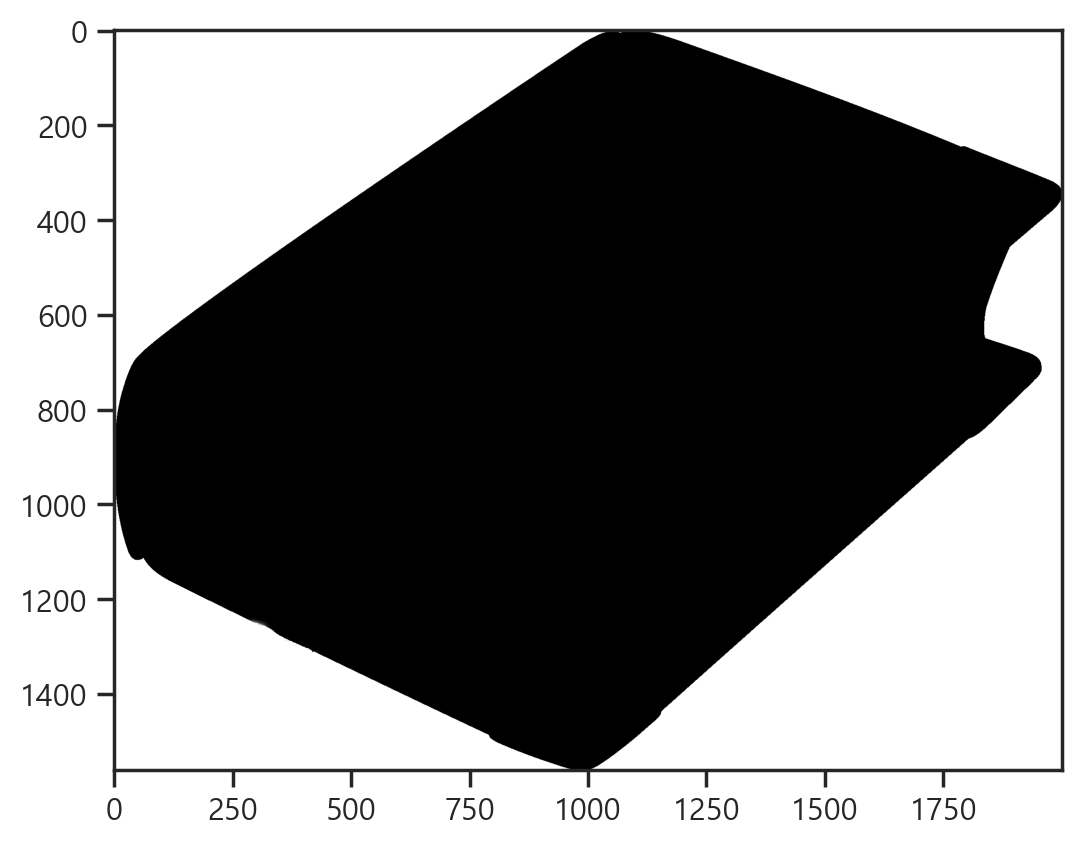

In [123]:
icon = Image.open("./book.png")   
plt.imshow(icon)


mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon, icon)
mask = np.array(mask)

In [64]:
def wdCloud(word_count):
    # font_path='C:/Windows/Fonts/Malgun Gothic'
    font_path='C:/Users/D/AppData/Local/Microsoft/Windows/Fonts/NanumSquareEB.ttf'

    wc = WordCloud(
        font_path=font_path,
        background_color='white',
        width=800,
        height=600,
        max_words=100,
        mask=mask,       
    )

    cloud=wc.generate_from_frequencies(word_count)
    plt.figure(figsize=(8,8))
    plt.imshow(cloud, interpolation='bilinear')  
    plt.axis('off')
    plt.show()

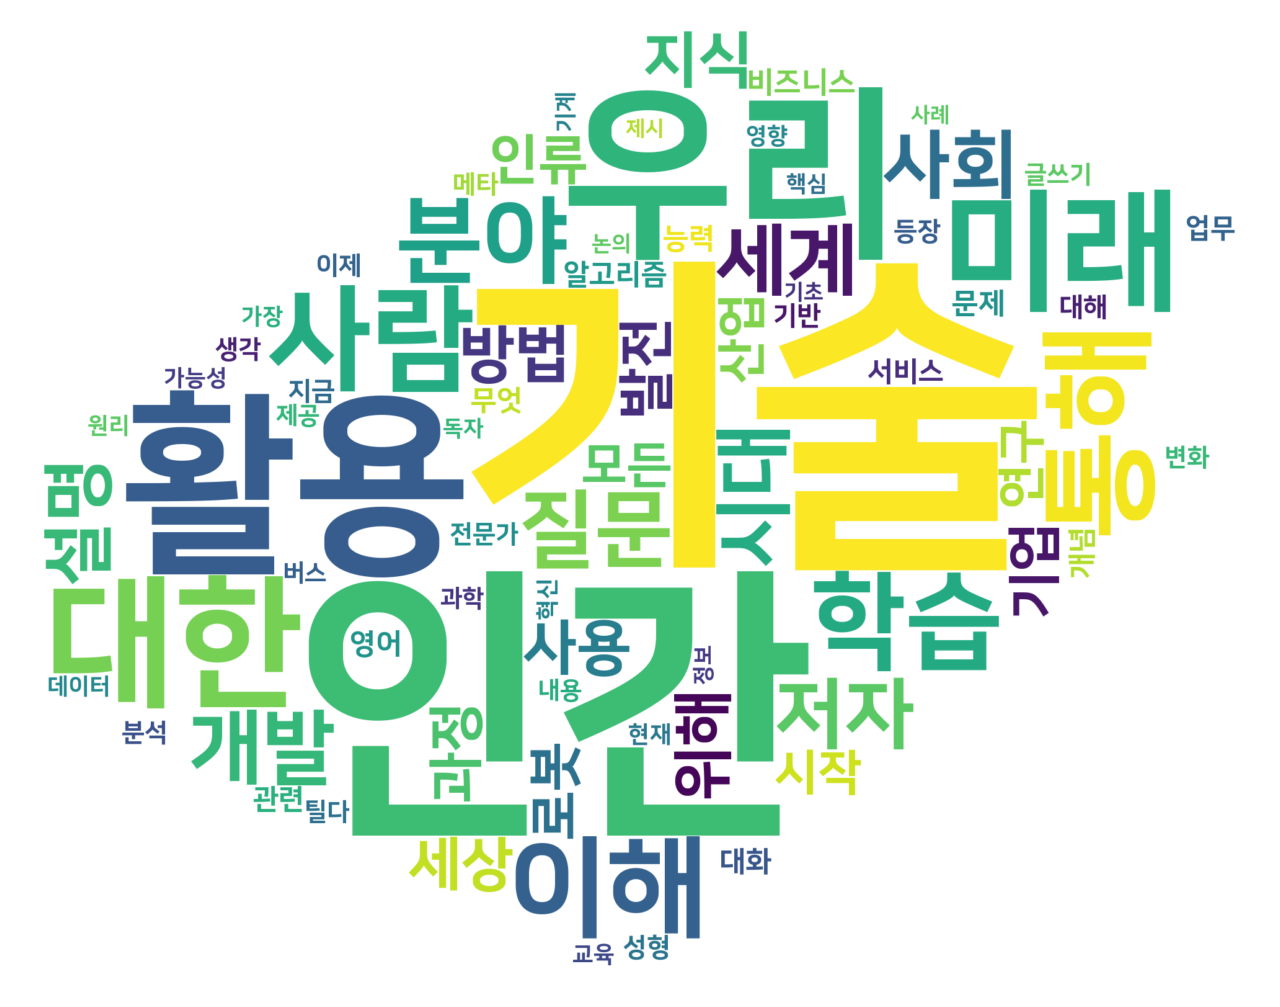

In [124]:
# 다른 분야의 책정보(컴퓨터/IT 분야 제외)
df_others = df_temp[df_temp['분야'] != '컴퓨터/IT']
df_others.reset_index(drop=True)
word(df_others,'book_info')

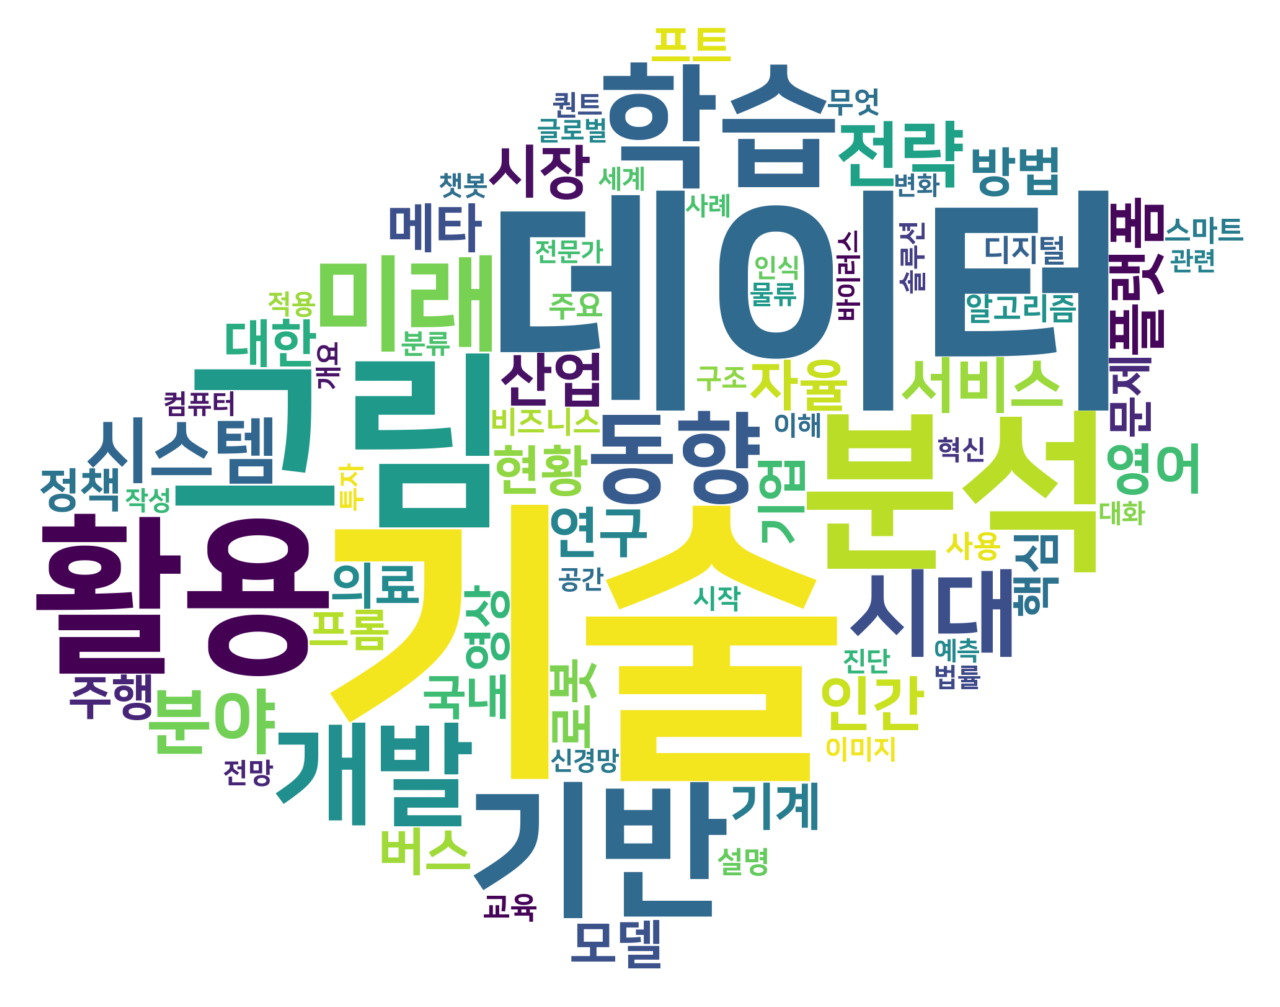

In [70]:
word(df_others,'index')

In [72]:
df_com = df_temp[df_temp['분야'] == '컴퓨터/IT']

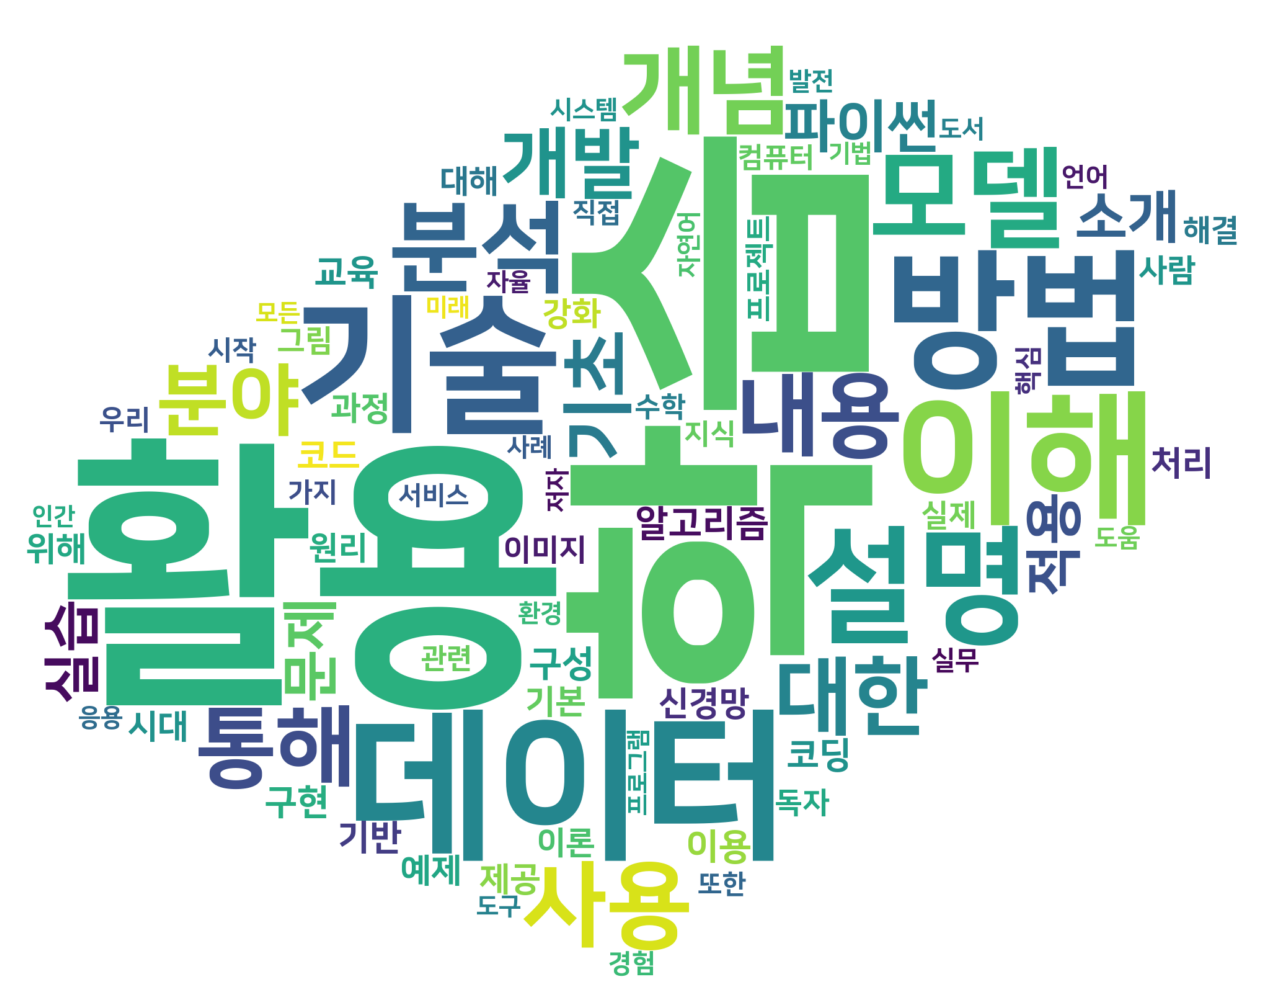

In [74]:
word(df_com,'book_info')

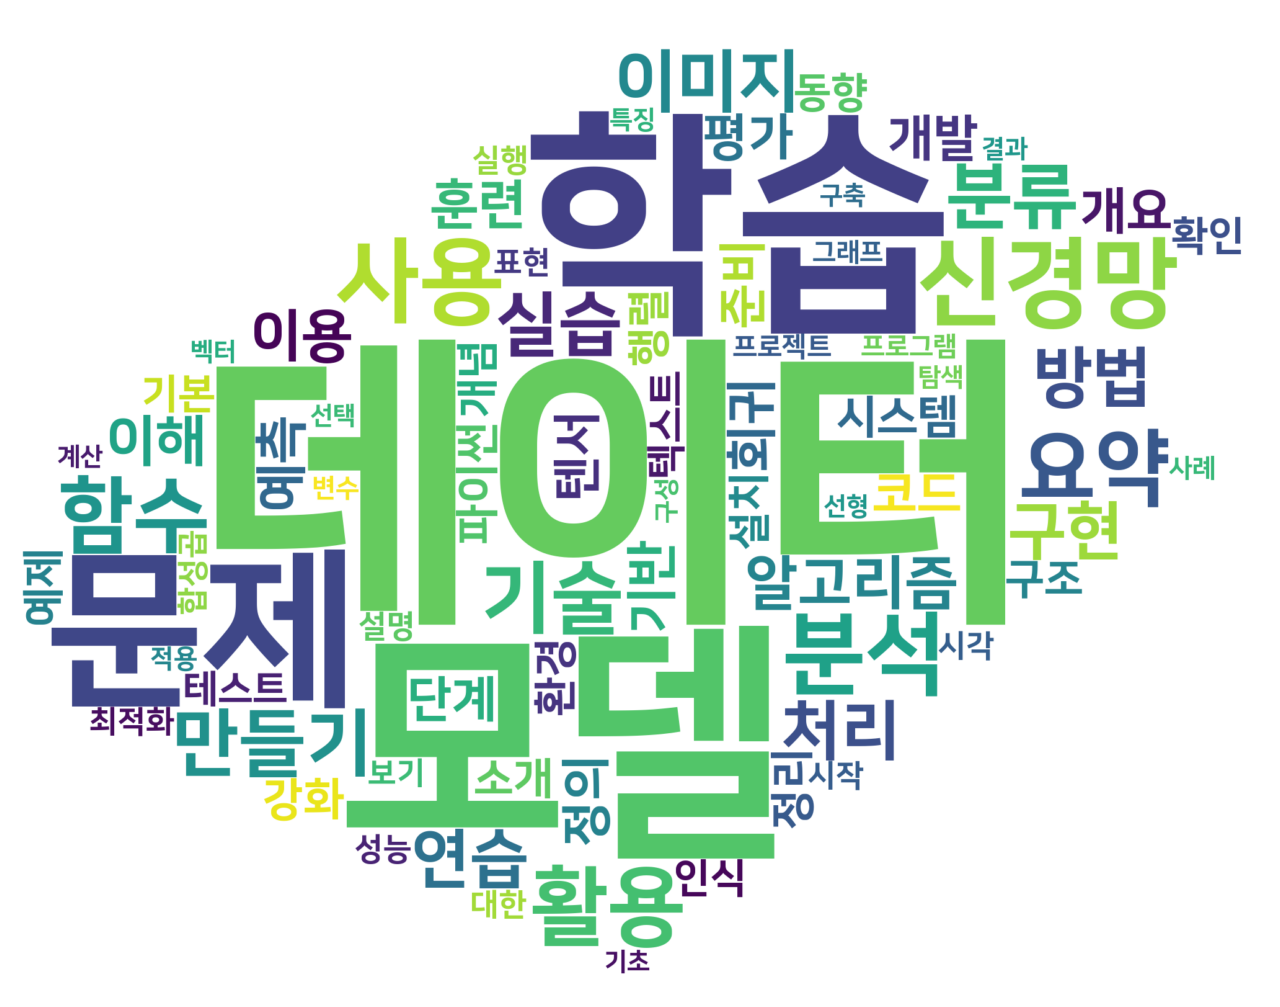

In [73]:
# 컴퓨터/IT 분야의 인덱스
word(df_com,'index')

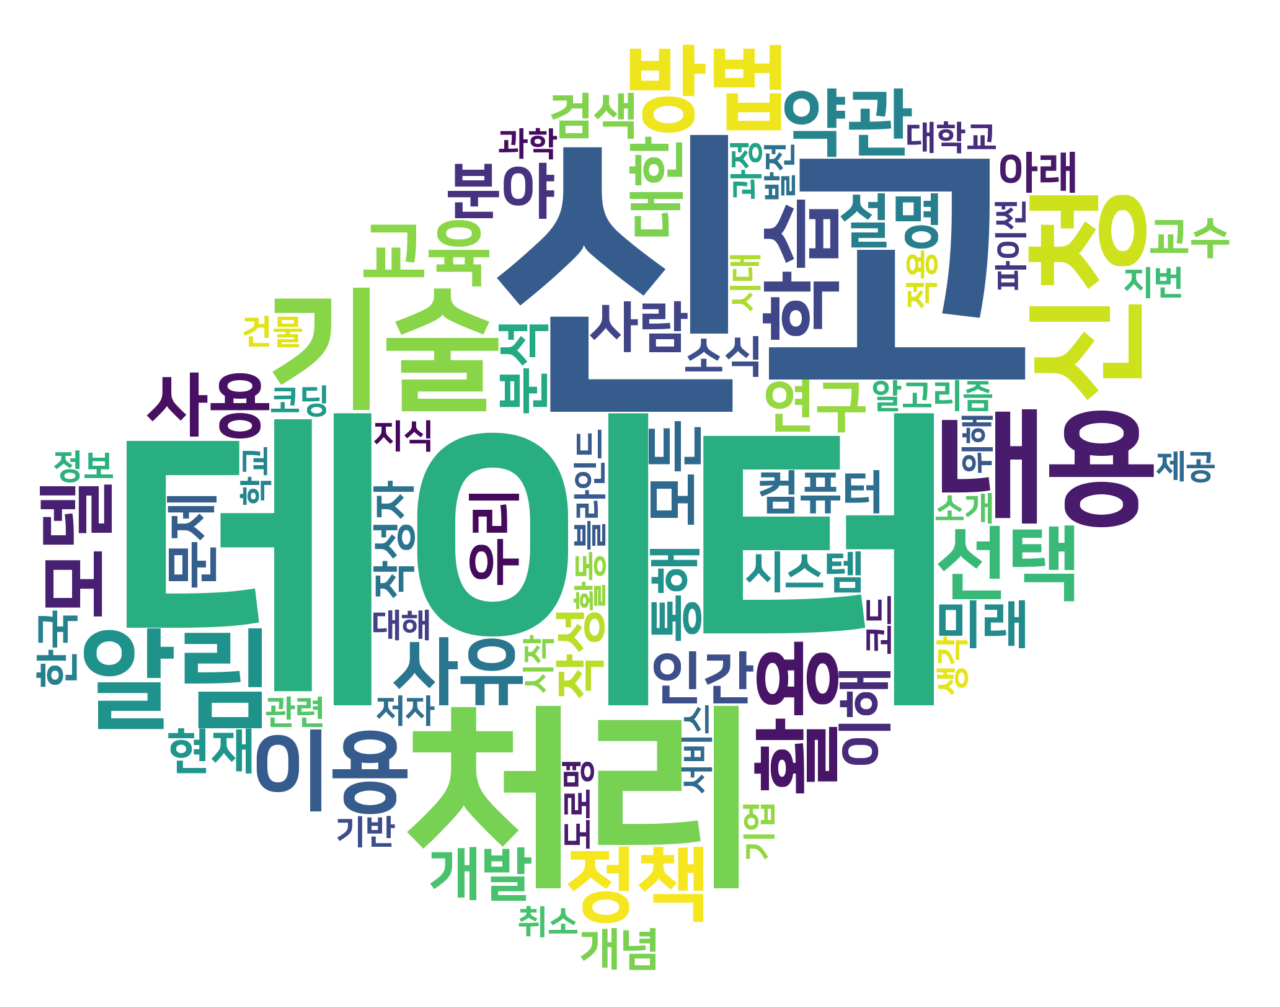

In [75]:
# 작가 정보(분야 구분 x)
word(df_temp,'author_info')

-> 작가에 대한 텍스트 마이닝도 해봤는데 불용어 처리를 다른 방식으로 시도해봐야하는지 개인적으로 의미 해석이 어렵다고 생각됩니다

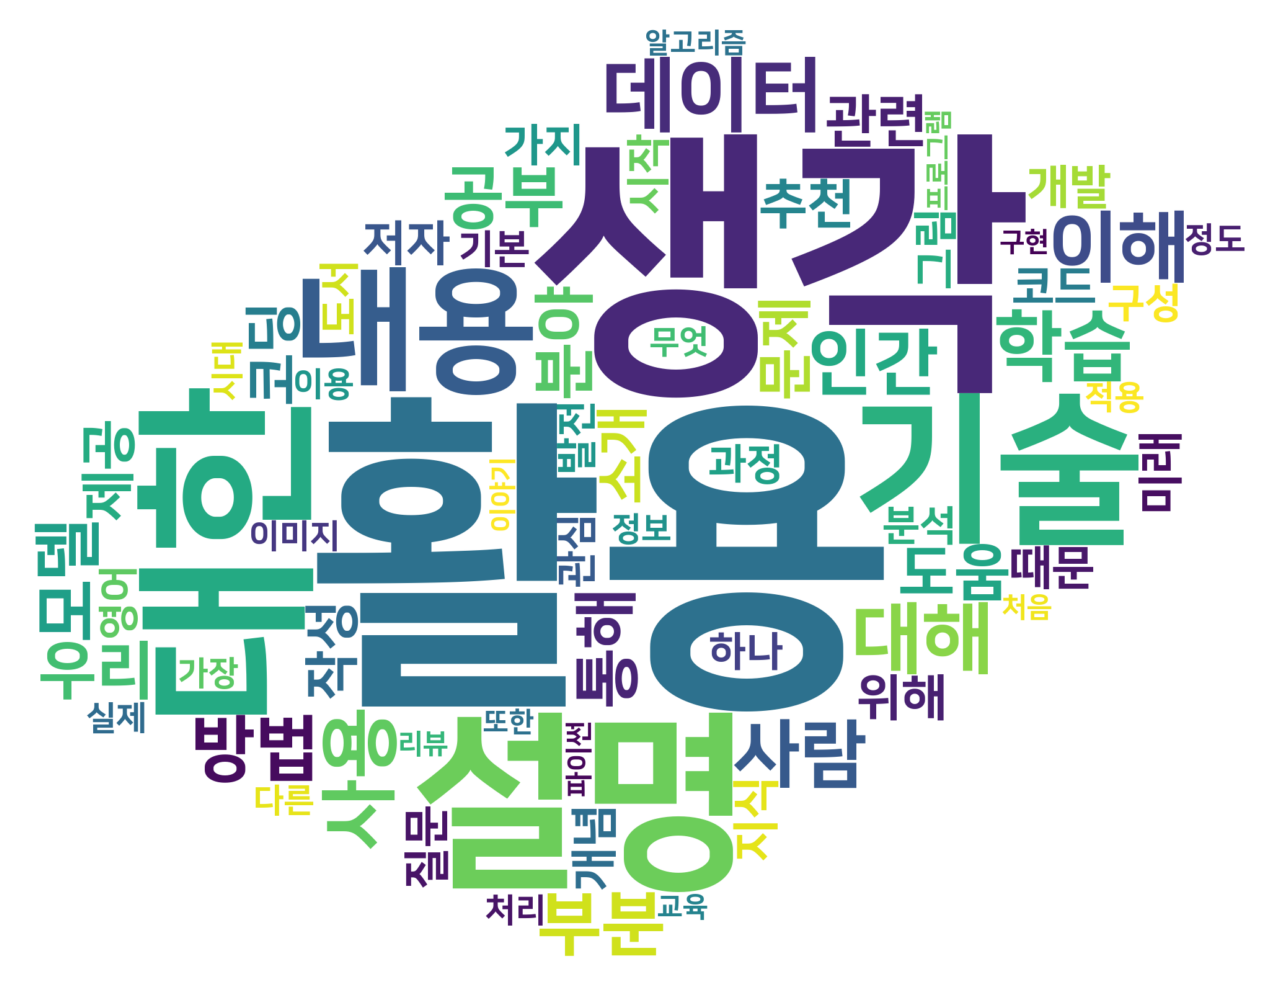

In [76]:
# 리뷰 정보(분야 구분 x)
word(df_temp,'review_text')

### 카테고리 세부 분석(경제경영 / 외국어 / 종교)

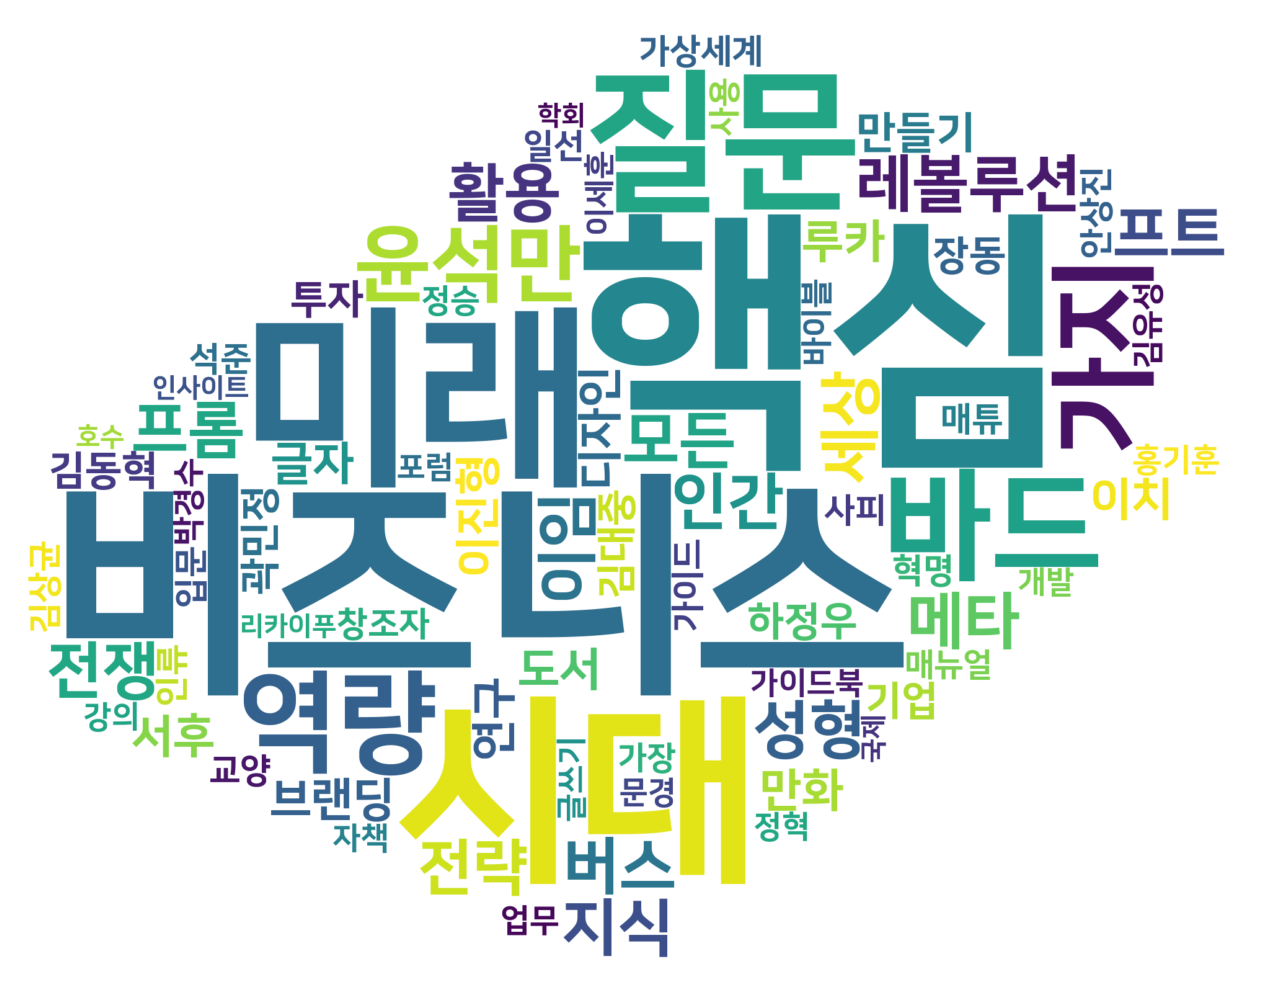

In [79]:
word(df_manage, 'title')

In [78]:
df_manage = df_temp[df_temp['분야']=='경제/경영']
df_manage

분야                                            title  \
18   경제/경영                        만화로 배우는 AI 인공지능 |  - 교보문고   
21   경제/경영  챗GPTㆍ바드 인공지능이 바꿔놓을 핵심역량 4가지(큰글자도서) | 윤석만 - 교보문고   
39   경제/경영                              AI 브랜딩 | 이서후 - 교보문고   
55   경제/경영             챗GPT, 이렇게 써먹으면 됩니다 | 후루카와 쇼이치 - 교보문고   
67   경제/경영                        AI 비즈니스 레볼루션 | 이진형 - 교보문고   
71   경제/경영                생성형 AI 프롬프트 디자인 | 생성형AI연구회 - 교보문고   
73   경제/경영              인공지능(AI)을 만들기 위한 핵심 지식 | 김동혁 - 교보문고   
74   경제/경영                   챗GPT시대 기업이 살아남는 법 | 장동인 - 교보문고   
85   경제/경영                               AI 전쟁 | 하정우 - 교보문고   
86   경제/경영                      AI에게 AI의 미래를 묻다 | 인공 - 교보문고   
97   경제/경영                    인공지능에 투자하고 싶습니다만 | 곽민정 - 교보문고   
103  경제/경영                  200% 활용하는 챗GPT 질문법 | 김대중 - 교보문고   
111  경제/경영                          가상세계의 창조자들 | 노석준 - 교보문고   
112  경제/경영                                 초인류 | 김상균 - 교보문고   
113  경제/경영                     교양인을 위한 챗GPT 지식 | 김일선 - 교보문고   
114  경제/경영                         챗GPT 입문 가이드 | 안상진 - 교보문고   
117  경제/경영         챗GPT·바드 인공지능이 바꿔놓을 핵심역량 4가지 | 윤석만 - 교보문고   
120  경제/경영                      메타버스 모든 것의 혁명 | 매튜 볼 - 교보문고   
125  경제/경영                            GPT 사피엔스 | 홍기훈 - 교보문고   
140  경제/경영                     세상에서 가장 쉬운 챗GPT | 김유성 - 교보문고   
145  경제/경영                      챗GPT 업무 사용 매뉴얼 | 박경수 - 교보문고   
152  경제/경영                            챗GPT 바이블 | 정승익 - 교보문고   
156  경제/경영             ChatGPT 활용 핵심 가이드북 | GPT 개발포럼 - 교보문고   
157  경제/경영          챗GPT 질문하는 인간, 답하는 AI(큰글자책) | 이임복 - 교보문고   
158  경제/경영                      챗GPT 프롬프트 레볼루션 | 변문경 - 교보문고   
161  경제/경영                         완벽한 챗GPT 강의 | 이정혁 - 교보문고   
166  경제/경영                챗GPT 질문하는 인간, 답하는 AI | 이임복 - 교보문고   
176  경제/경영                          챗GPT시대 글쓰기 | 이세훈 - 교보문고   
198  경제/경영                            AI 2041 | 리카이푸 - 교보문고   
215  경제/경영                 비즈니스 전략을 위한 AI 인사이트 | 이호수 - 교보문고   
219  경제/경영                인공지능 메타버스 시대 미래전략 | 국제미래학회 - 교보문고   
228  경제/경영                            로봇의 지배 | 마틴 포드 - 교보문고   
229  경제/경영                              퀀트의 세계 | 홍창수 - 교보문고   
240  경제/경영                          거의 모든 인공지능 | 문용석 - 교보문고   
289  경제/경영            AI 메이커스, 인공지능 전쟁의 최전선 | 케이드 메츠 - 교보문고   
356  경제/경영                      인공지능으로 구현되는 세상 | 강성배 - 교보문고   
384  경제/경영                       신뢰할 수 있는 인공지능 | 한상기 - 교보문고   
416  경제/경영                              AI 임팩트 | 이주선 - 교보문고   
441  경제/경영                비즈니스 의사결정을 위한 인공지능이론 | 김상봉 - 교보문고   
473  경제/경영                            공간 웹 | 가브리엘 르네 - 교보문고   

                                                 index  \
18   감수의 글 _ 인공지능 활용법을 알기 쉽게 설명한다 프롤로그 _ 앞으로 인공지능 사...   
21   프롤로그 인공지능(AI)은 계산기다 Chapter1 인공지능(AI)이 바꿔놓을 세상...   
39   추천의 글책 속의 전략 미리 보기미래 전략 키워드 5가지INTRO. 10년 후, 내...   
55   시작하며프롤로그제1장 엄청난 반향을 일으킨 대화형 AI엄청난 관심이 쏟아진 대화형 ...   
67   프롤로그 인공지능 시대, 변화의 흐름에 올라타라Chapter 1 지금, 챗GPT를 ...   
71   제1부 생성형 AI의 이해와 효율적인 대화법　1장 생성형 AI의 사용 및 효율적인 ...   
73   추천사 003들어가는 글 010서문_챗GPT vs. 바드, 위대한 생성형 AI의 서...   
74   CHAPTER 01 한 편의 영화처럼 등장한 ChatGPT 이야기개발자도 예상하지 ...   
85   머리말1장 거부할 수 없는 지적 혁명의 시작인공지능 시대의 개막이 의미하는 것인공지...   
86   프롤로그 지은이의 말_AI의 미래에 대한 챗GPT와의 놀라운 대화첫 번째 대화 인공...   
97   머리말 _ ‘모두의 인공지능’으로 좀 더 스마트하게 투자하는 법       1장 챗...   
103  지은이의 말1장 챗GPT 활용의 99%는 질문이다챗GPT 활용의 핵심은 ‘질문’이다...   
111  추천사프롤로그서문Chapter 1 : 과거단테, 인류 최초로 사후 세계 가상공간을 ...   
112  프롤로그PART 1. 존재의 진화CHAPTER 1. 인간- 정신을 확장한다- 육체를...   
113  1. 소문난 잔치2. 지능이란 무엇일까?지능에겐 목적이 있다 능력은 수단이해한 걸까...   
114  I. 내 이름은 챗GPT예요01. 챗GPT가 무엇이죠?  1002. 챗GPT 이렇게...   
117  프롤로그 인공지능(AI)은 계산기다 Chapter1 인공지능(AI)이 바꿔놓을 세상...   
120  한국의 독자들에게_ 앞으로 10년, 실리콘밸리를 뛰어넘을 기업이 한국에서 나온다 추...   
125  프롤로그 | 상식과 사회적 맥락에서 바라본 챗GPTPART1 기술 혁신의 사회적 맥...   
140  지은이의 말 _ IT 지식이 많지 않은 일반인을 위한 챗GPT 입문서!1장 챗봇에 ...   
145  이 책의 활용법01. 챗GPT 질문 입력 가이드02. 챗GPT 업무 적용 가이드들어...   
152  Ⅰ. 알아두면 유익한 챗GPT 지식1. 챗GPT 탄생 배경2. 인공지능의 역사3. ...   
156  머리말\t\t\t01 AI 혁명의 시작, ChatGPT\t\t\tAI 혁명 중심에 ...   
157  일러두기 - 챗GPT와 함께한 출판 기획PART 

In [104]:
df_temp["분야"].unique()

array(['과학', '컴퓨터/IT', '정치/사회', '자기계발', '경제/경영', '어린이(초등)', '기술/공학', '인문',
       '종교', '외국어', '청소년'], dtype=object)

In [105]:
df_teenage = df_temp[df_temp['분야'] == '청소년']

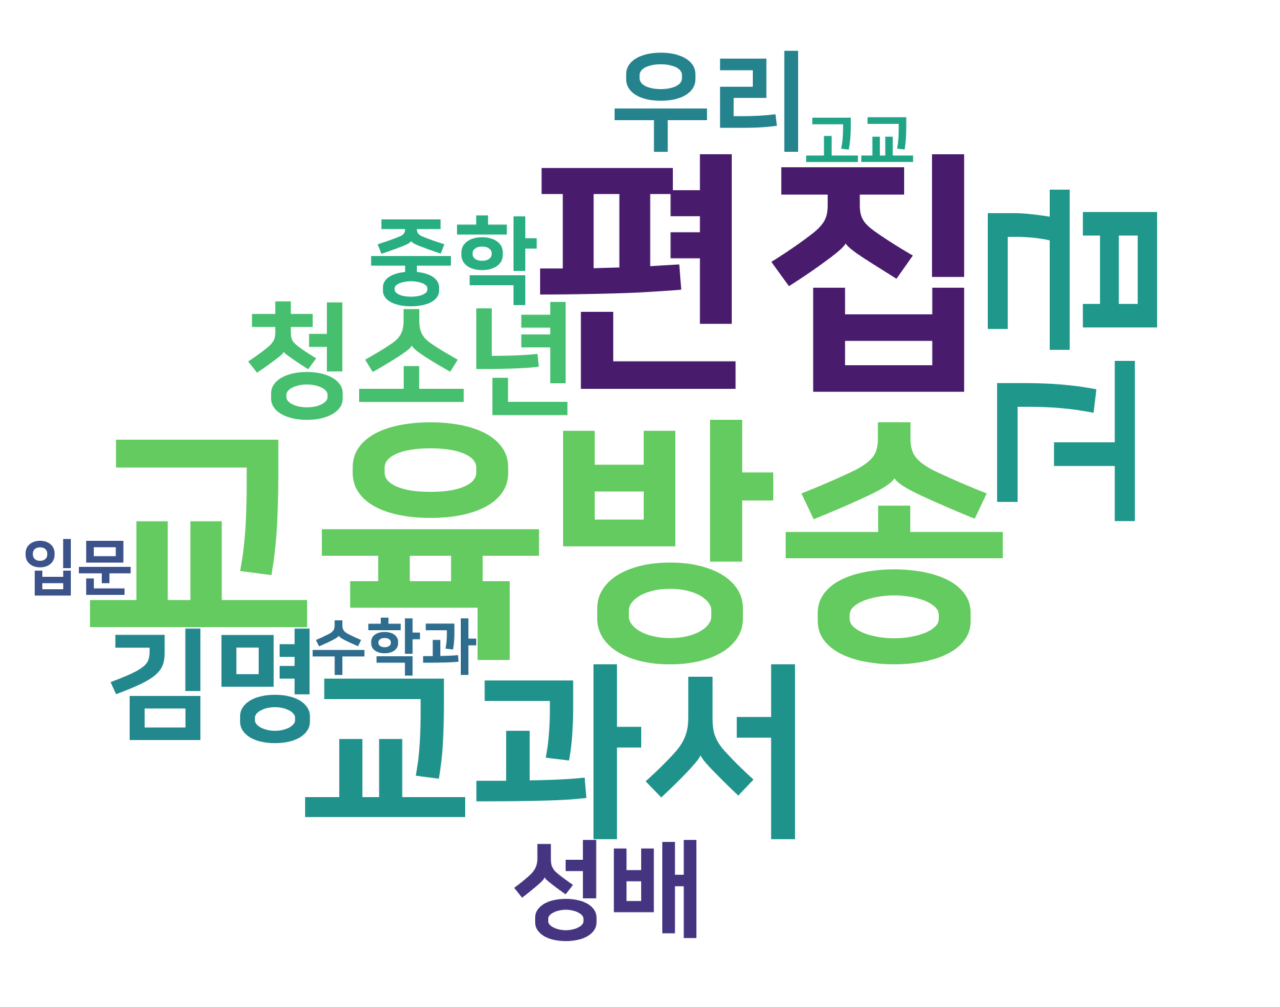

In [106]:
word(df_teenage,'title')

In [107]:
df_lng = df_temp[df_temp['분야']=='외국어']

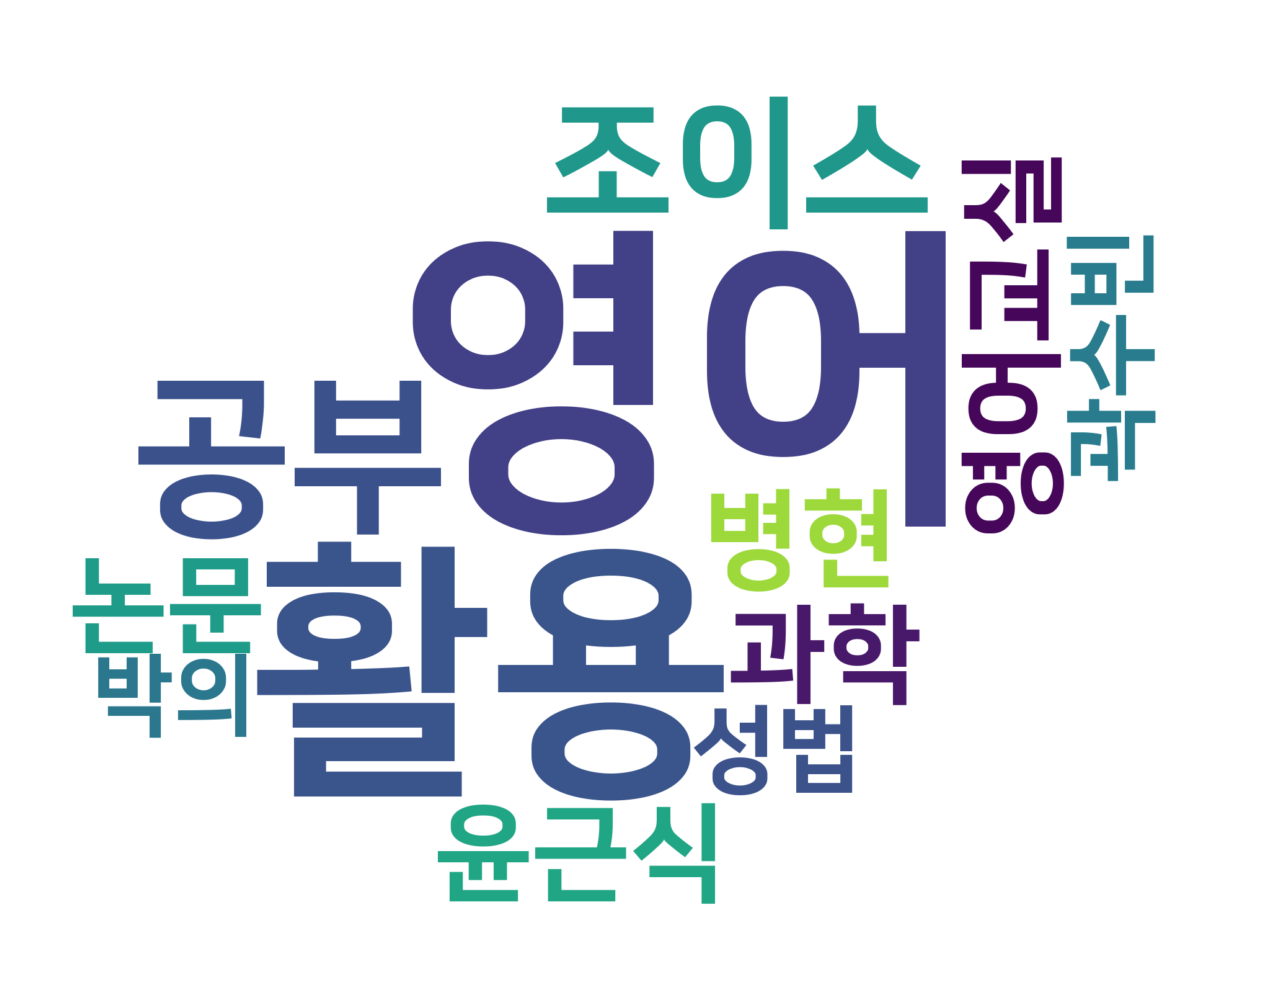

In [108]:
word(df_lng,'title')

In [119]:
df_rel = df_temp[df_temp['분야']=='정치/사회']

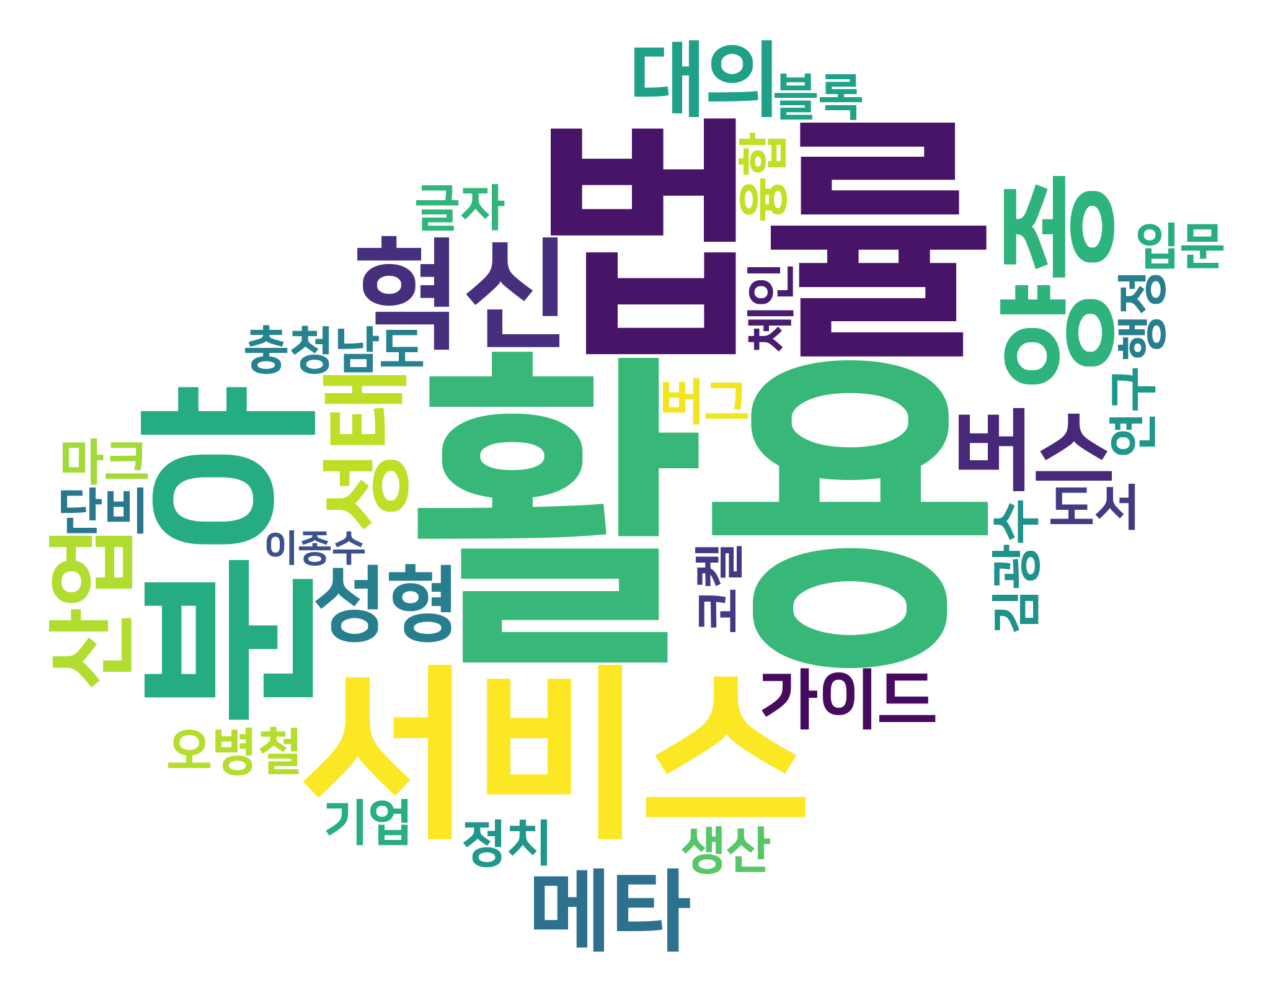

In [120]:
word(df_rel,'title')

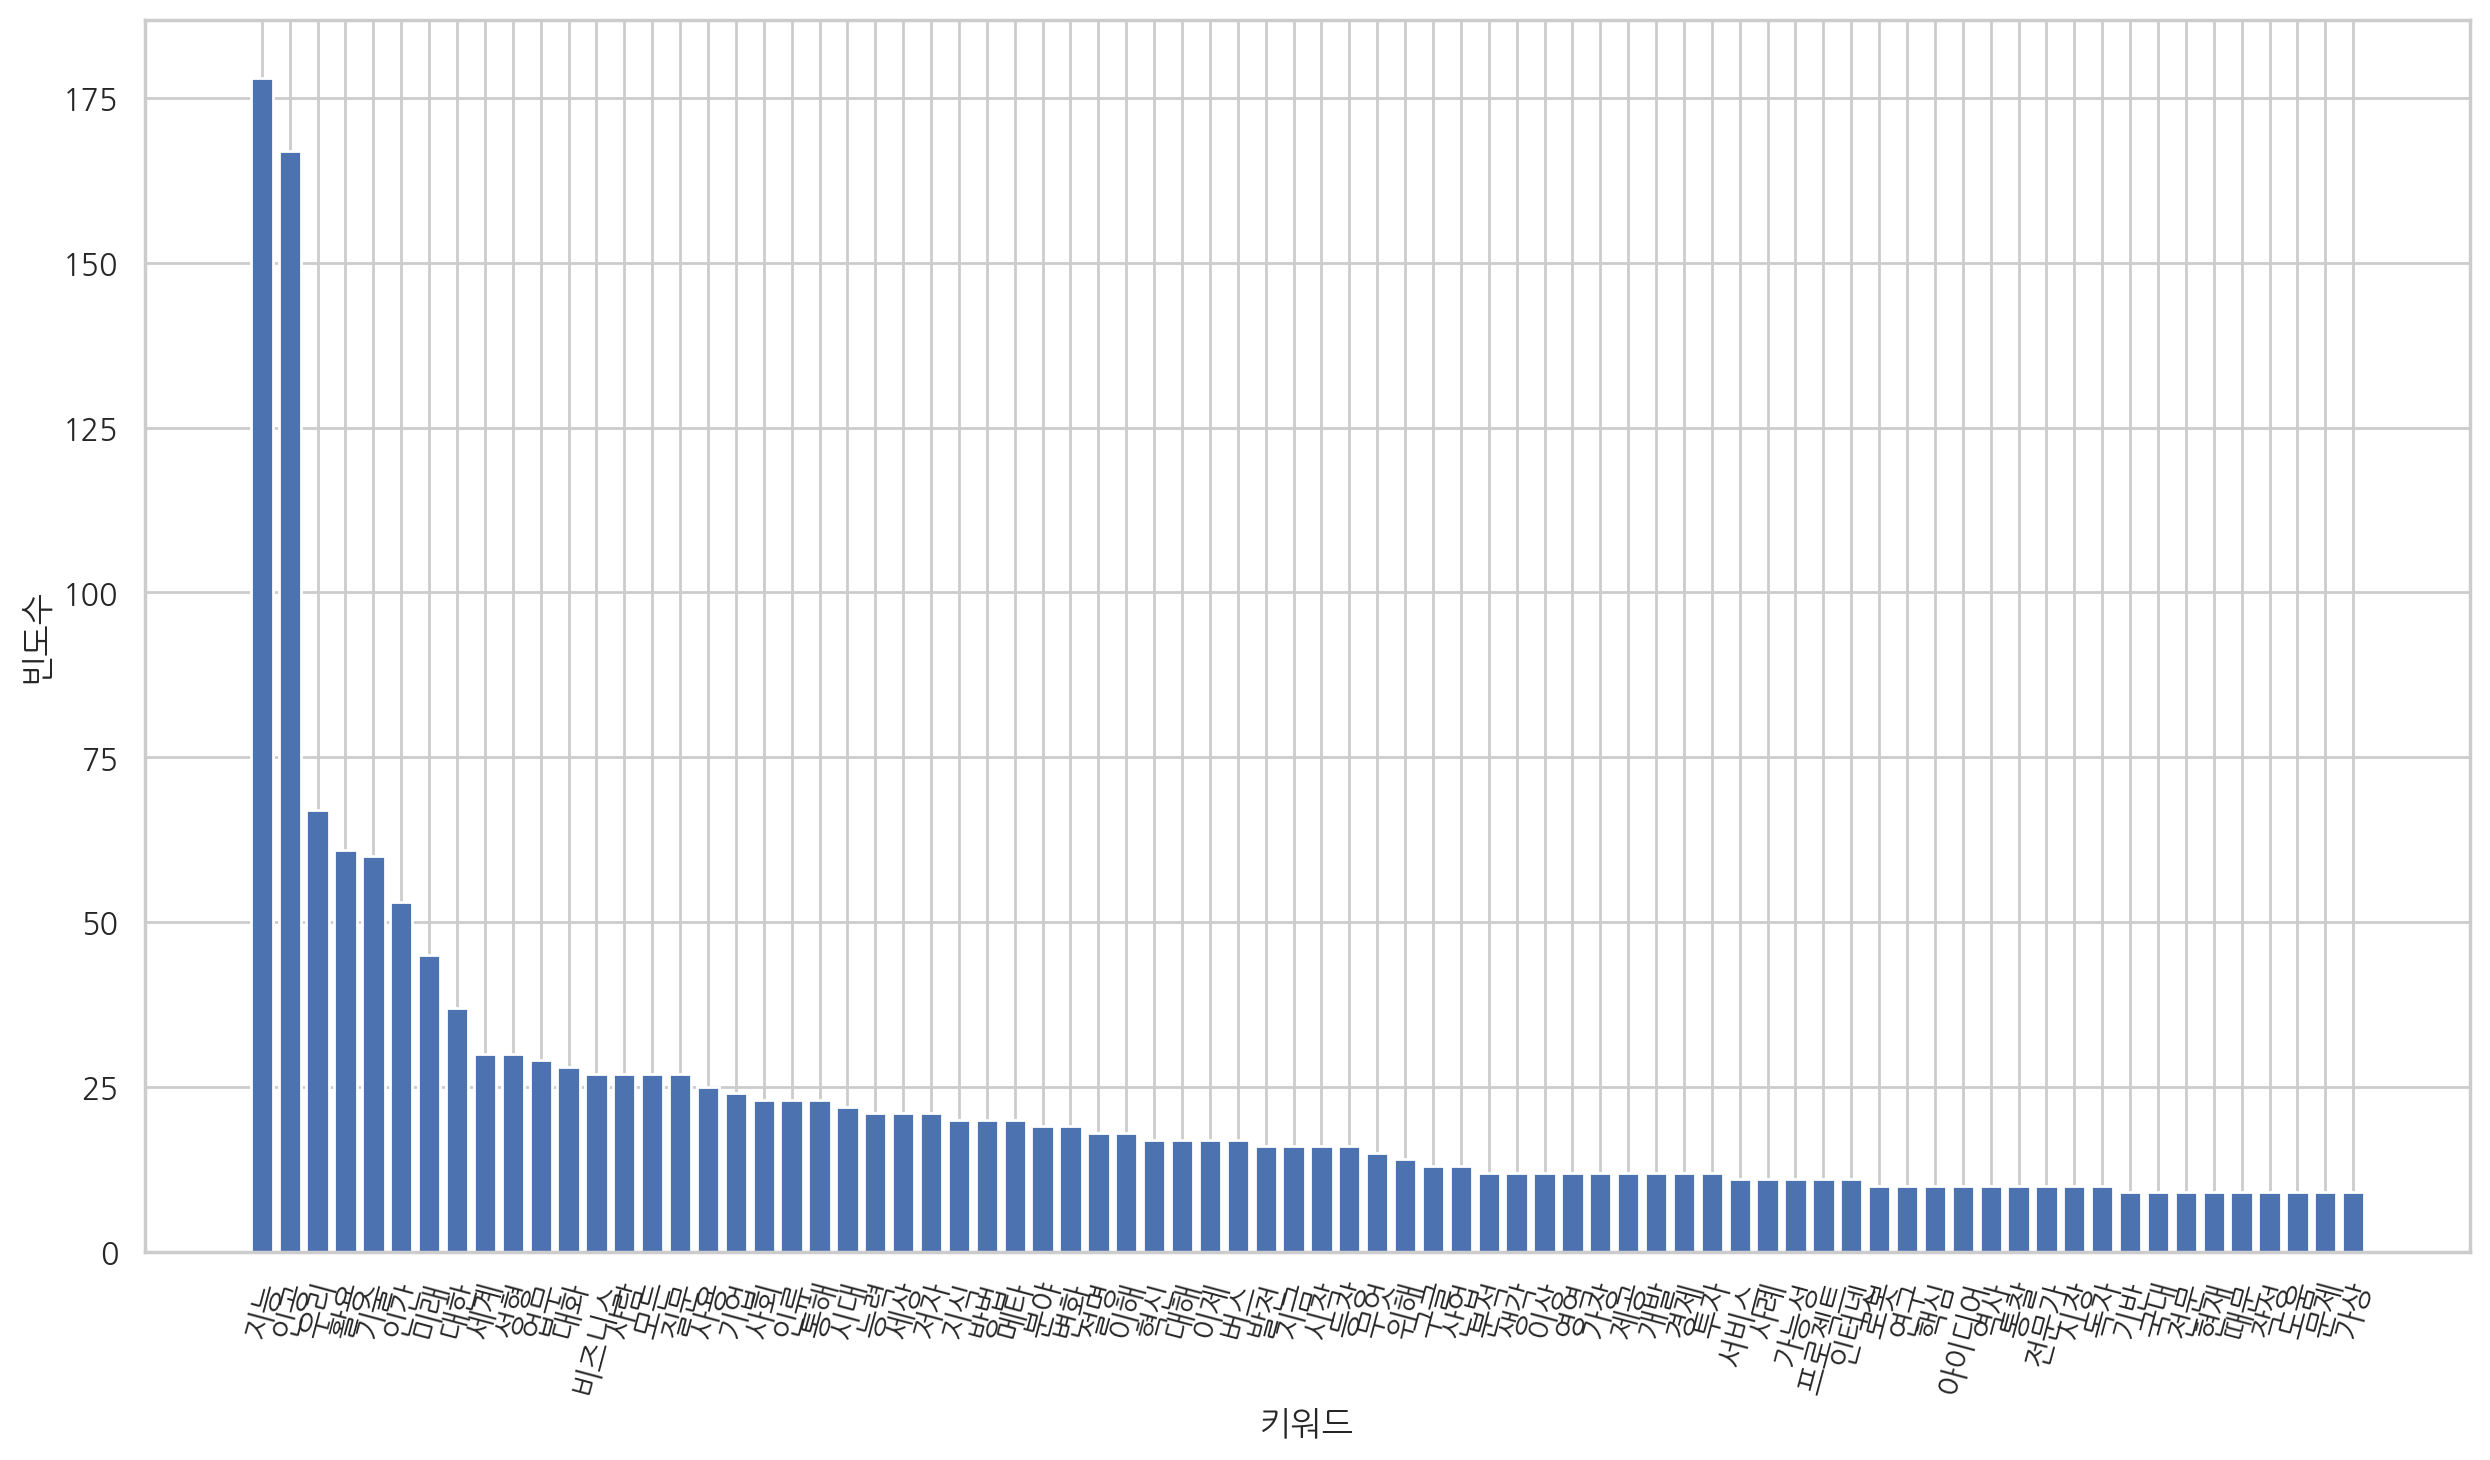

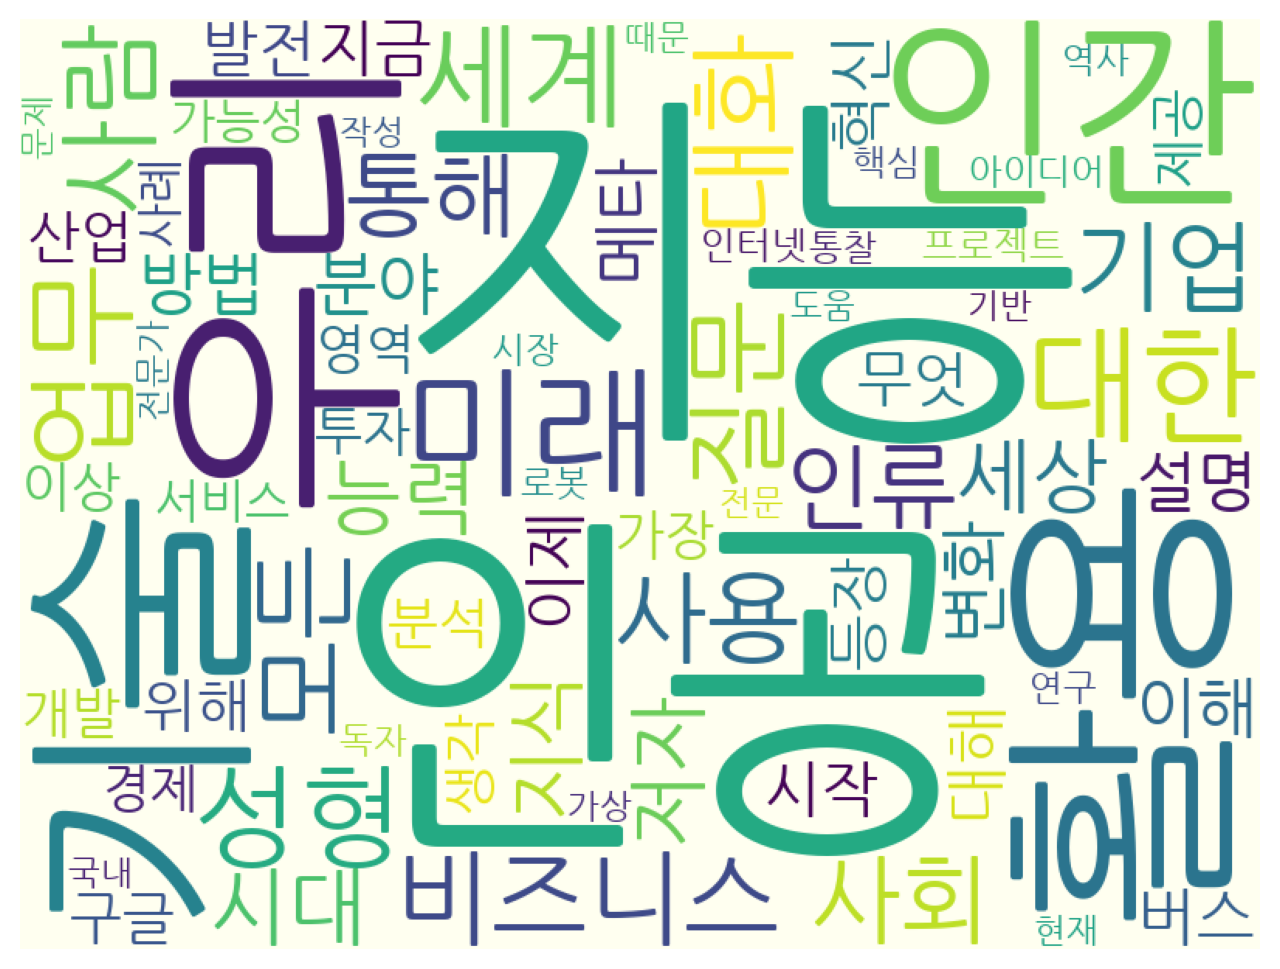

In [156]:
#경제/경영 책정보
word(df_manage,'book_info')

인공, 지능 단어를 제외하면 비즈니스, 업무, 기업 등의 단어가 자주 확인됨

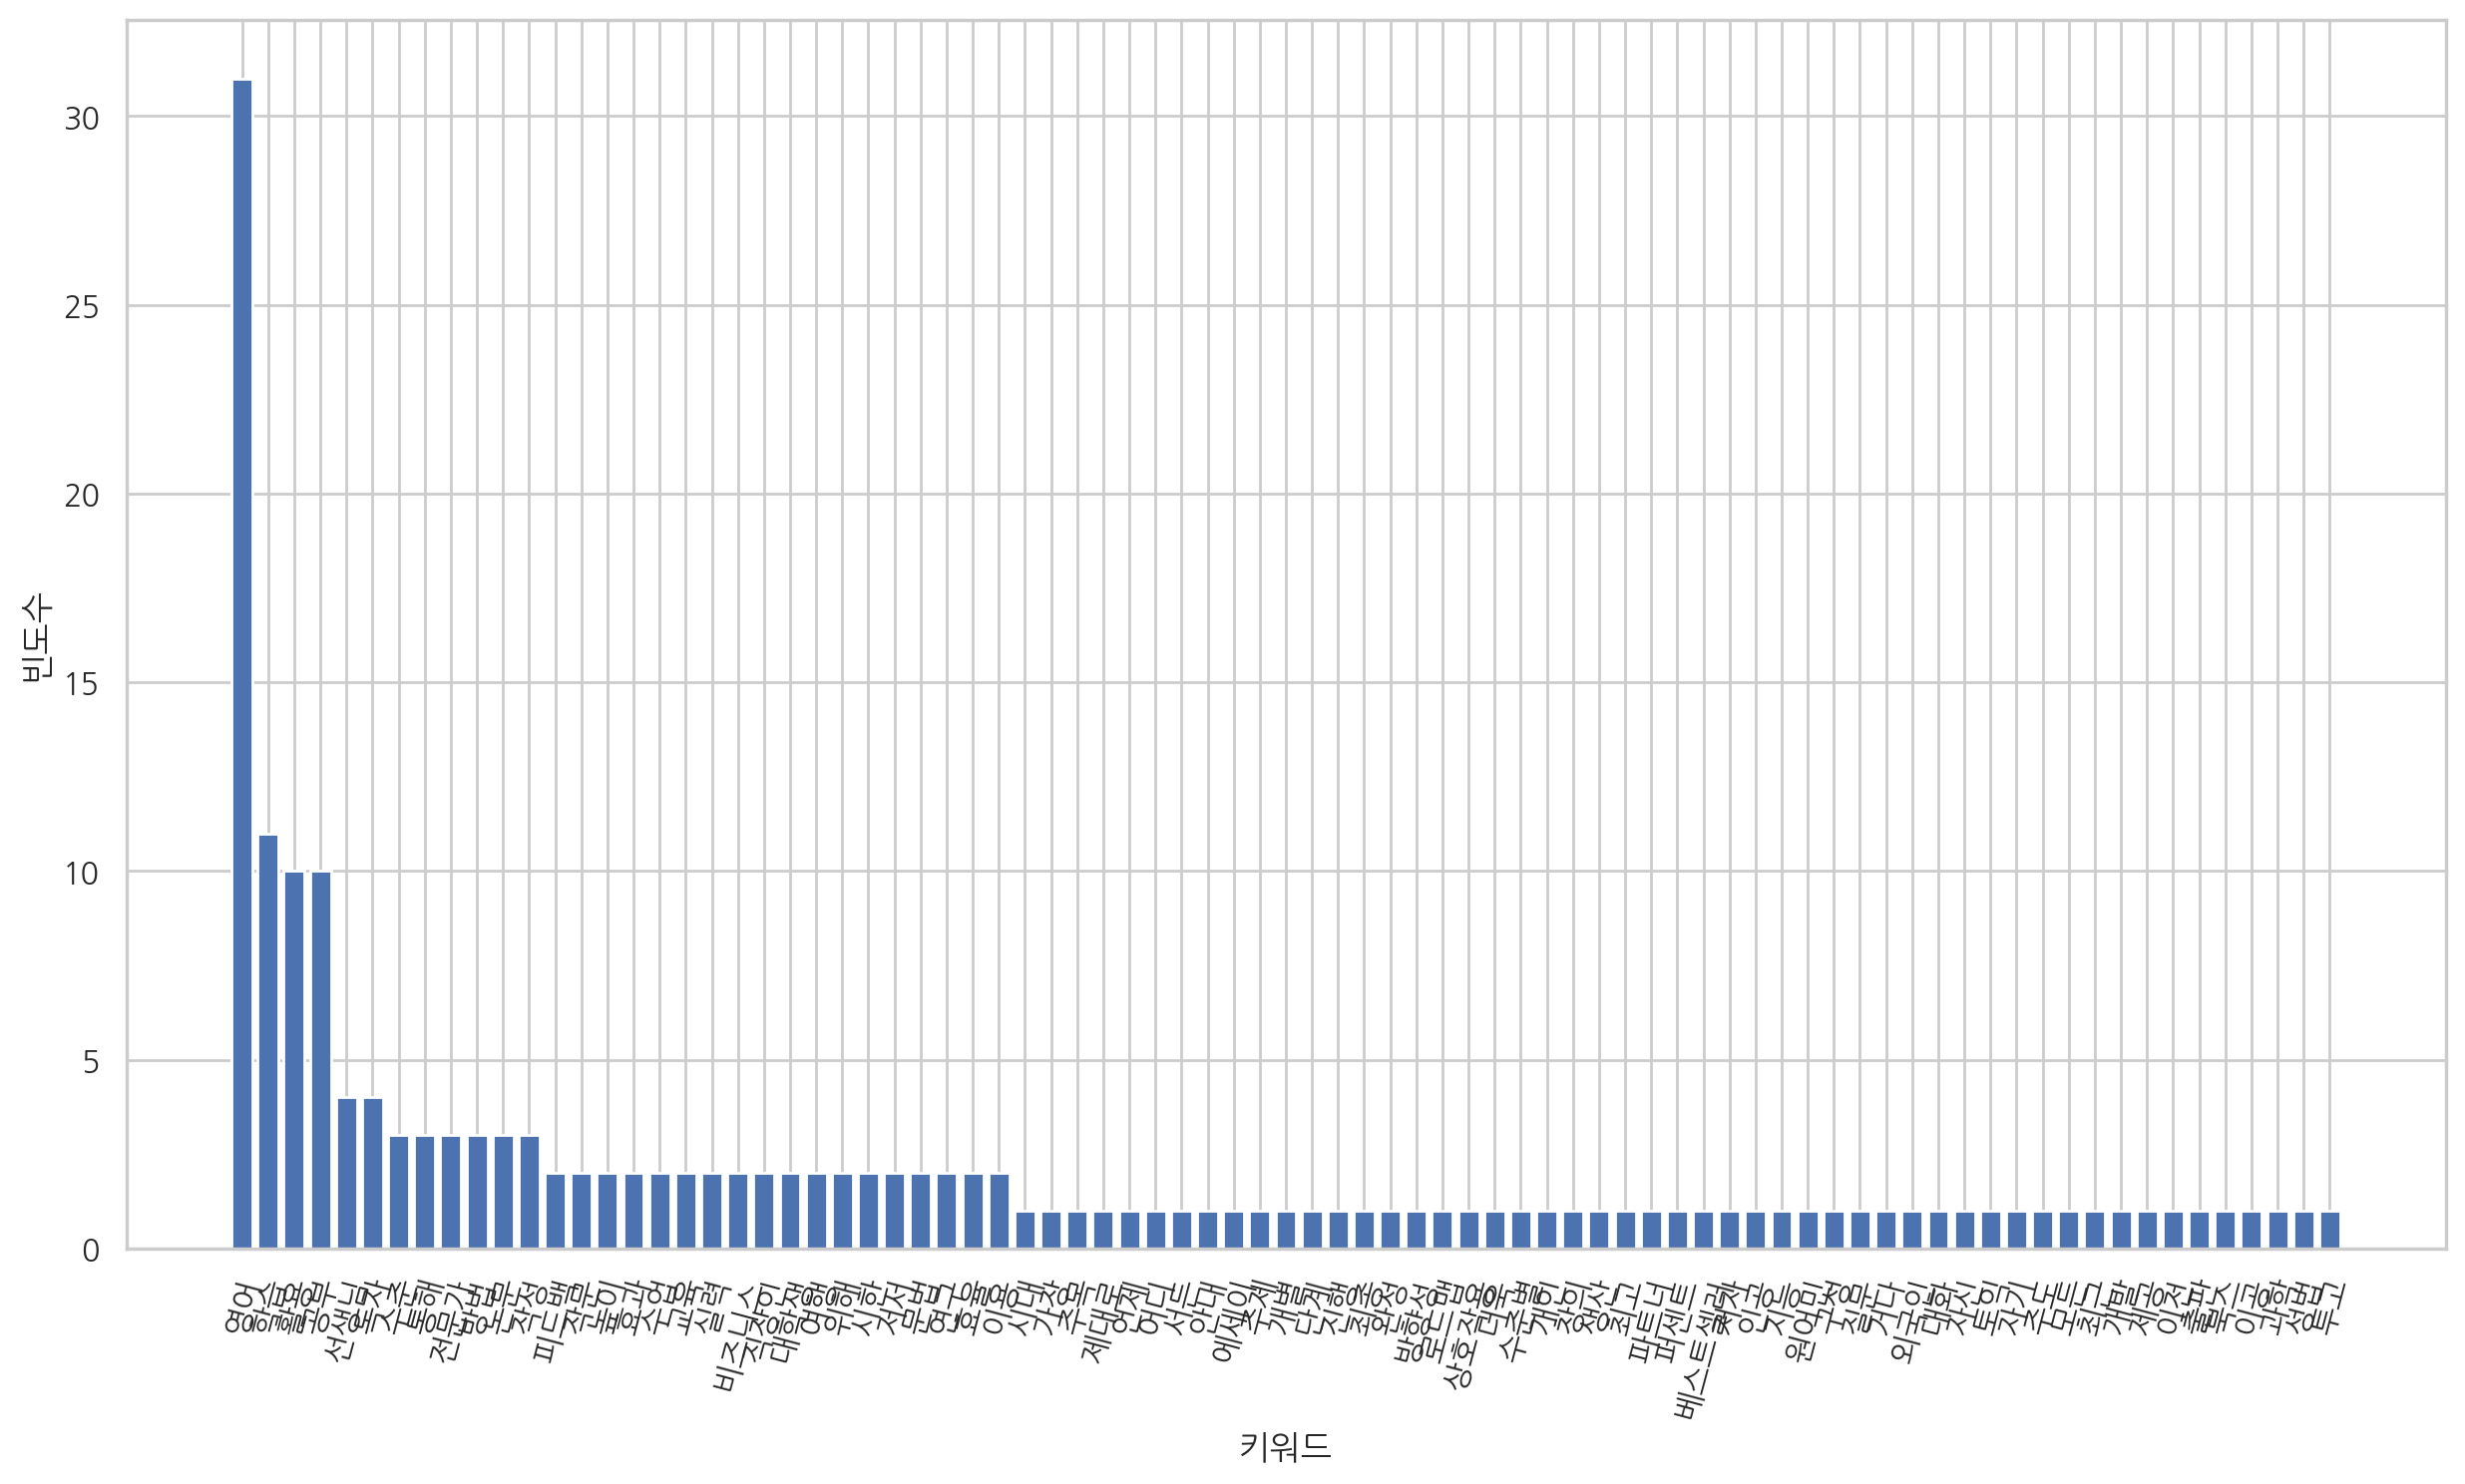

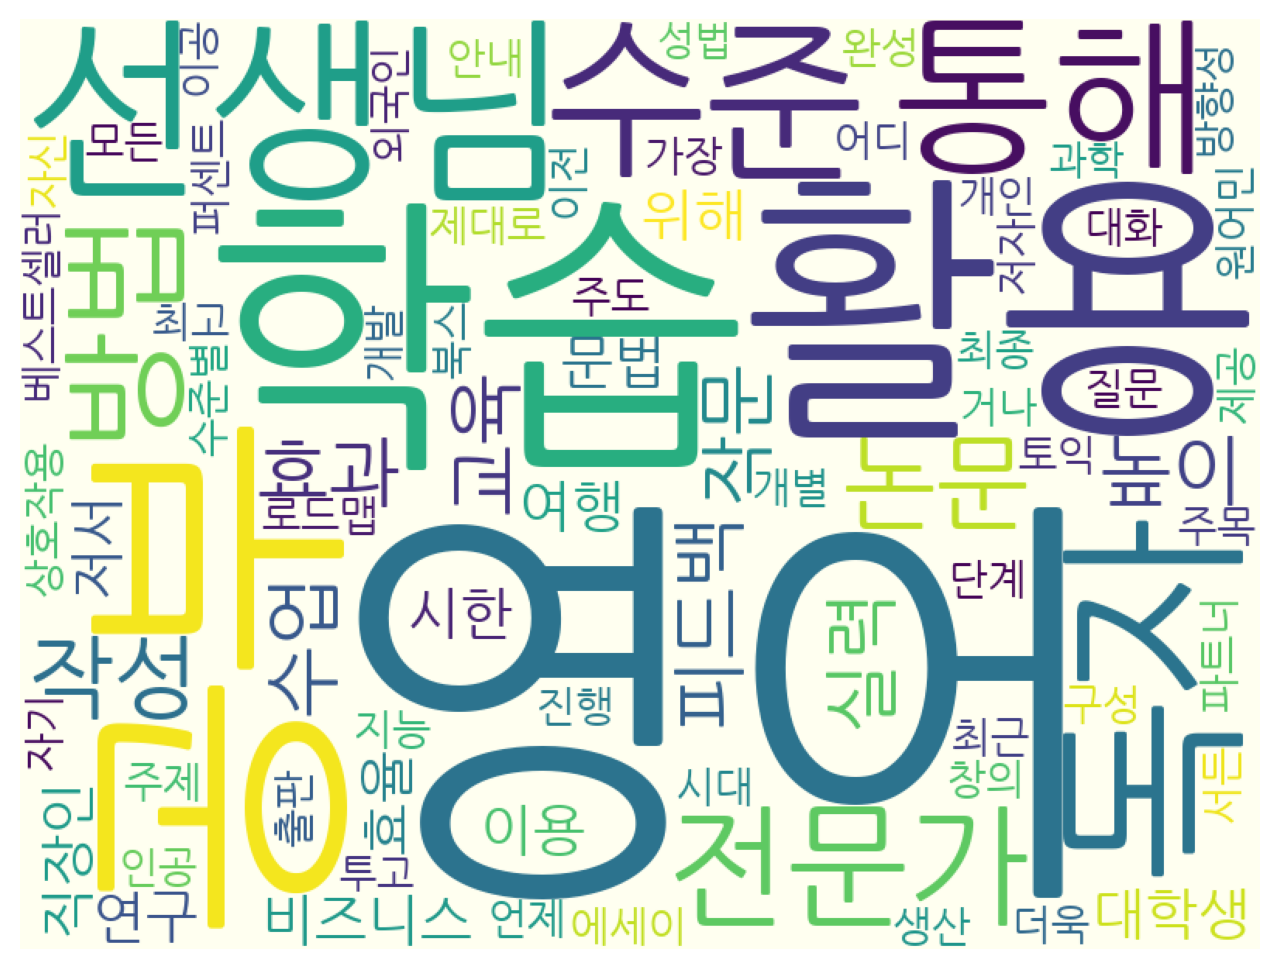

In [157]:
# 외국어 분야 책정보
word(df_lng,'book_info')

영어, 학습 등의 단어를 확인 할 수 있음. 인공, 지능에 대한 내용도 등장하는 것으로 보이나 그 빈도가 낮음

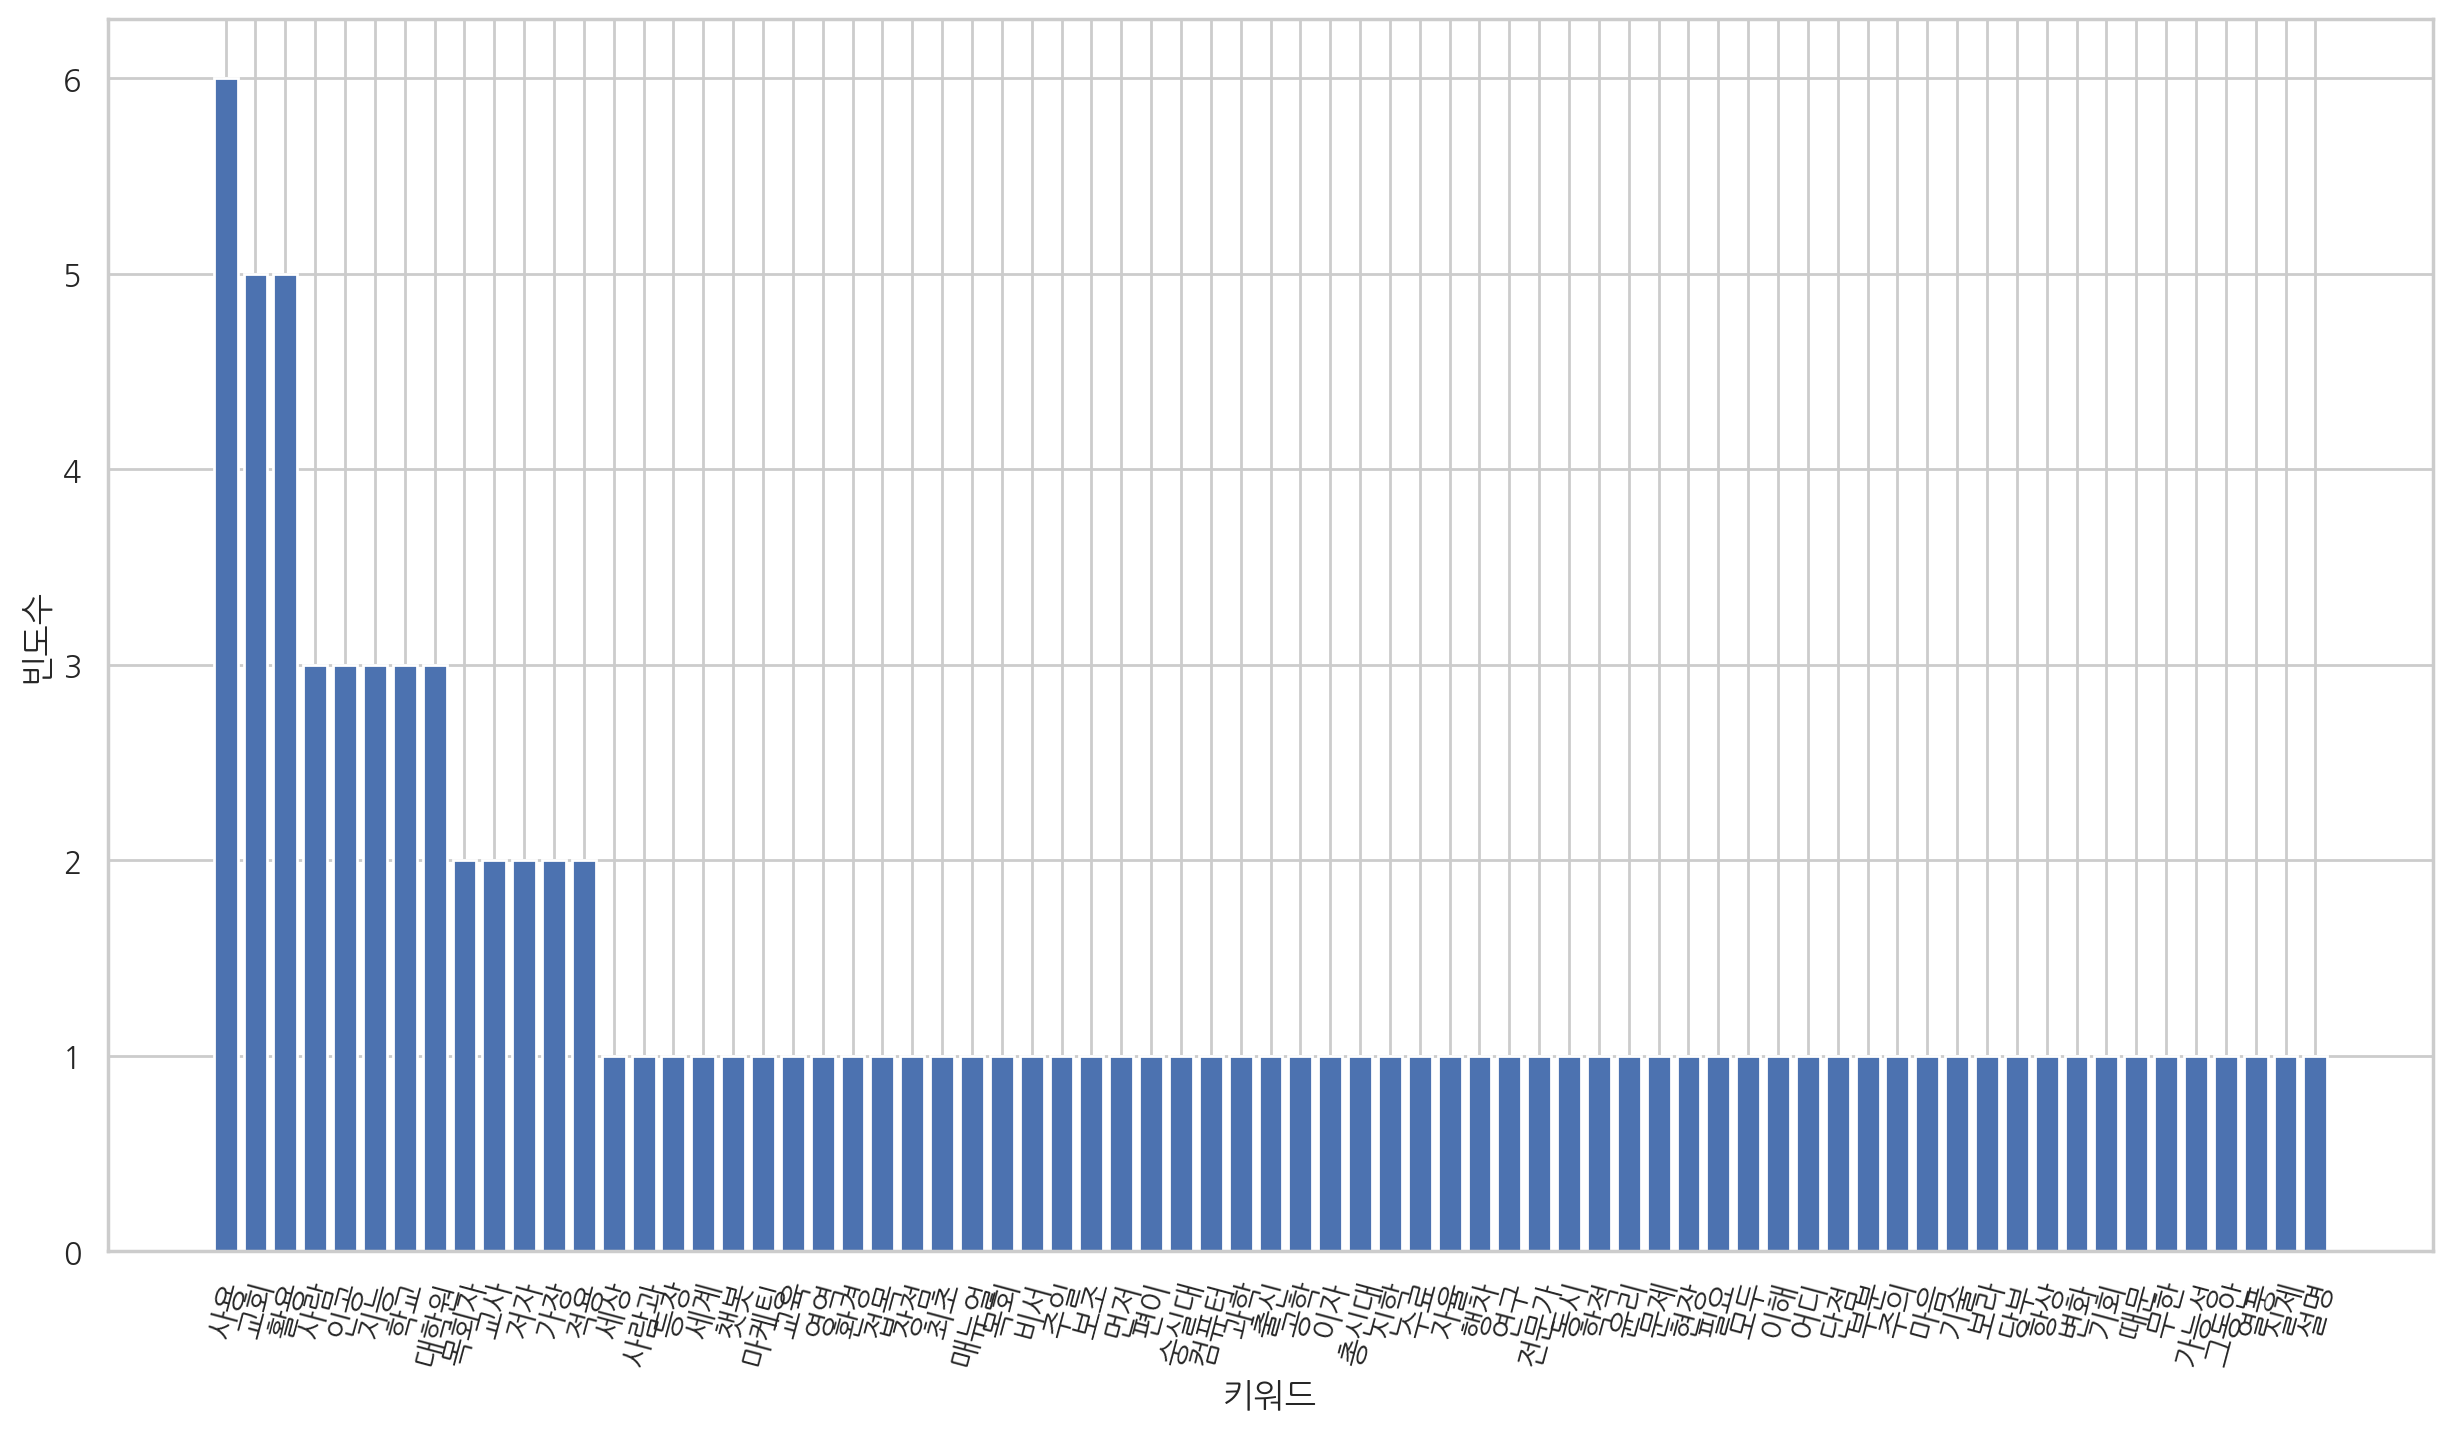

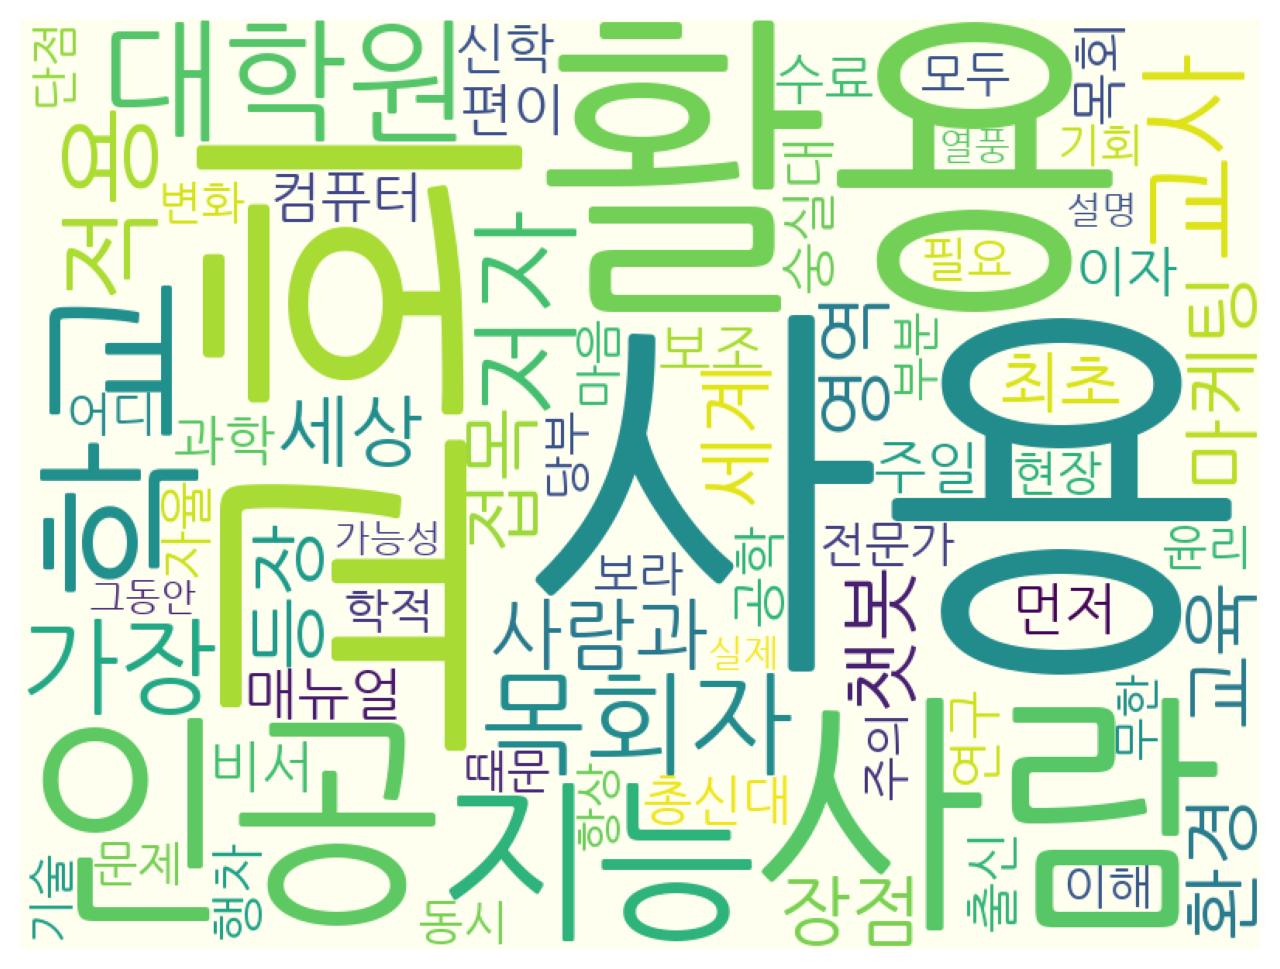

In [158]:
#종교 분야 책정보
word(df_rel,'book_info')

종교 관련 단어가 많이 나타남. 컴퓨터, 과학, 챗봇 등 정보기술과 관련된 단어도 어느정도 등장함을 확인 할 수 있음

### 정형 데이터 EDA

In [159]:
df.columns

Index(['순번', '상품코드', '판매상품ID', '상품명', '정가', '판매가', '할인율', '적립율', '적립예정포인트',
       '인물', '출판사', '발행(출시)일자', '분야', 'title', 'index', 'book_info',
       'author_info', 'review_rate', 'review_count', 'page', 'review_text'],
      dtype='object')

In [81]:
df_struct = df[['정가','판매가','할인율','적립율','적립예정포인트','발행(출시)일자','review_rate','review_count','page']]
df_struct

정가     판매가  할인율 적립율 적립예정포인트  발행(출시)일자  review_rate  review_count  \
0    17,500  15,750  10%  5%     870  20231130          0.0           0.0   
1    58,000  52,200  10%  5%   2,900  20231130          0.0           0.0   
2    25,000  22,500  10%  5%   1,250  20231201          0.0           0.0   
3    20,000  19,000   5%  3%     600  20231031          0.0           0.0   
4    22,000  19,800  10%  5%   1,100  20231130          0.0           0.0   
..      ...     ...  ...  ..     ...       ...          ...           ...   
491  36,000  36,000   0%  3%   1,080  20210113         10.0           2.0   
492  20,000  18,000  10%  5%   1,000  20210126          7.5           3.0   
493  18,000  18,000   0%  3%     540  20201030          0.0           0.0   
494  14,000  12,600  10%  5%     700  20210107          9.5           7.0   
495  19,000  17,100  10%  5%     950  20210112          0.0           0.0   

     page  
0    256쪽  
1    876쪽  
2    300쪽  
3    264쪽  
4    312쪽  
..    ...  
491  432쪽  
492  208쪽  
493  215쪽  
494  168쪽  
495  464쪽  

[496 rows x 9 columns]

In [83]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
df_struct.loc[:, '정가'] = df_struct['정가'].str.replace(',', '').astype(int)
df_struct.loc[:, '판매가'] = df_struct['판매가'].str.replace(',', '').astype(int)
df_struct.loc[:, '할인율'] = df_struct['할인율'].str.replace('%', '').astype(int)
df_struct.loc[:, '적립율'] = df_struct['적립율'].str.replace('%', '').astype(int)
df_struct.loc[:, '적립예정포인트'] = df_struct['적립예정포인트'].str.replace(',', '').astype(int)
df_struct.loc[:, 'page'] = df_struct['page'].str.replace('쪽', '').fillna(0).astype(int)

In [85]:
df_cor = df_struct.apply(pd.to_numeric, errors='coerce')

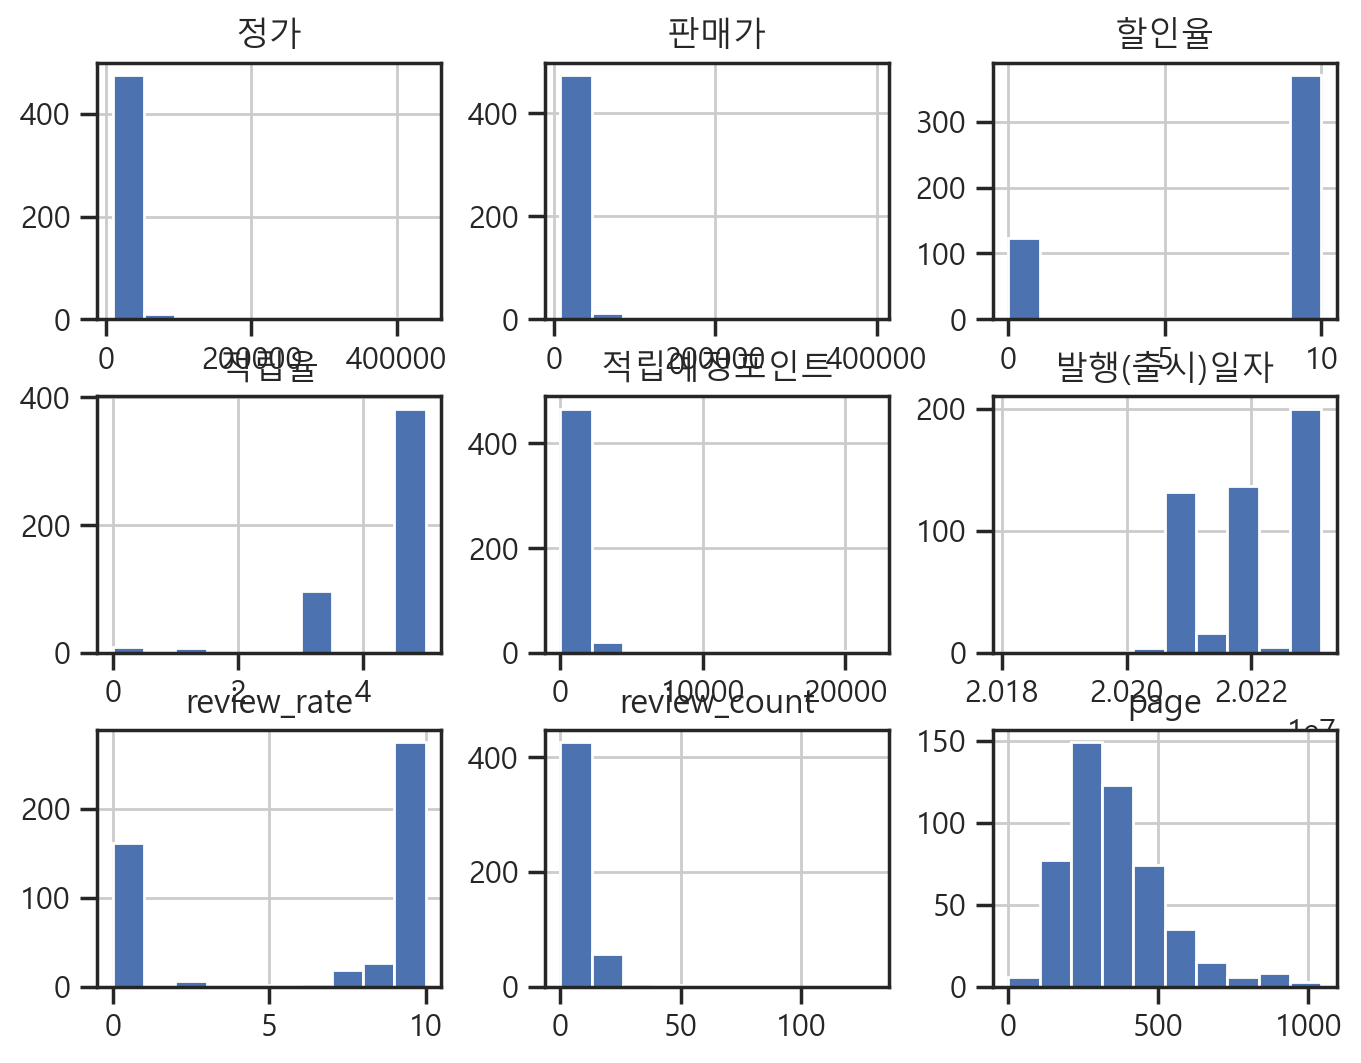

In [86]:
df_cor.hist(figsize=(8,6));

In [87]:
def hist(col_name):
    plt.hist(df_cor[col_name], bins=20, alpha=1.0)
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.show()

In [88]:
cols = df_cor.columns
cols

Index(['정가', '판매가', '할인율', '적립율', '적립예정포인트', '발행(출시)일자', 'review_rate',
       'review_count', 'page'],
      dtype='object')

In [97]:
df.loc[:, '정가'] = df['정가'].str.replace(',', '').astype(int)

In [98]:
df.sort_values(by="정가", ascending=False)[:10]

순번           상품코드         판매상품ID  \
132  133  9791191512250  S000202013445   
163  164  9791186934937  S000201230043   
312  313  9791190870320  S000001945151   
476  481  9791158621667  S000001769951   
490  495  9791185497259  S000001869248   
257  258  9791188593491  S000061451177   
187  188  9791189250188  S000200778263   
477  482  9791186934555  S000001894882   
274  275  9791196990107  S000060629149   
273  274  9791196990114  S000060629150   

                                                   상품명      정가      판매가  할인율  \
132                 2023 인공지능(AI) 및 빅데이터 기술개발 동향과 시장전망  440000  396,000  10%   
163                 글로벌 인공지능(AI) 기술개발 동향과 사업화 전략(2023)  440000  396,000  10%   
312  인간 증강 기술로 주목받는, AI 기반 로봇(사이보그, 감성로봇, 챗봇)과 의료 로...  440000  396,000  10%   
476                                인공지능 주요산업별 비즈니스 트렌드  380000  342,000  10%   
490                설명가능한 인공지능(XAI) 기술동향과 데이터 산업의 시장 전망  380000  342,000  10%   
257                  미래 기술의 중심 인공지능(AI) 기술개발전략 및 정책 동향  360000  324,000  10%   
187  초거대 AI(Artificial Intelligence) 산업 기술 주요 대학 연구...  350000  315,000  10%   
477      미국 연구개발 테마 총서 Vol 5: 딥러닝(Deep Learning)(2020)  300000  270,000  10%   
274                                        틸다(TILDA) 1  127000  114,300  10%   
273                                        틸다(TILDA) 2  127000  114,300  10%   

    적립율 적립예정포인트               인물  ...  발행(출시)일자      분야  \
132  5%  22,000          산업동향연구소  ...  20230504  컴퓨터/IT   
163  5%  22,000   씨에치오 얼라이언스 편집부  ...  20230222  컴퓨터/IT   
312  5%  22,000   IRS Global 편집부  ...  20220314   기술/공학   
476  5%  19,000  지식산업정보원 R&D정보센터  ...  20210201   기술/공학   
490  5%  19,000           하연 편집부  ...  20210112   기술/공학   
257  1%   3,600          KIB 편집부  ...  20220711   기술/공학   
187  5%  17,500     IPResearch센터  ...  20230130   기술/공학   
477  5%  15,000   씨에치오 얼라이언스 편집부  ...  20201231   기술/공학   
274  5%   6,350   틸다 그리고 함께한 사람들  ...  20220422      인문   
273  5%   6,350   틸다 그리고 함께한 사람들  ...  20220422      인문   

                                                 title  \
132  2023 인공지능(AI) 및 빅데이터 기술개발 동향과 시장전망 | 산업동향연구소 -...   
163  글로벌 인공지능(AI) 기술개발 동향과 사업화 전략(2023) | 씨에치오 얼라이언...   
312  인간 증강 기술로 주목받는, AI 기반 로봇(사이보그, 감성로봇, 챗봇)과 의료 로...   
476       인공지능 주요산업별 비즈니스 트렌드 | 지식산업정보원 R&D정보센터 - 교보문고   
490  설명가능한 인공지능(XAI) 기술동향과 데이터 산업의 시장 전망 | 하연 편집부 -...   
257  미래 기술의 중심 인공지능(AI) 기술개발전략 및 정책 동향 | KIB 편집부 - ...   
187  초거대 AI(Artificial Intelligence) 산업 기술 주요 대학 연구...   
477  미국 연구개발 테마 총서 Vol 5: 딥러닝(Deep Learning)(2020) ...   
274                틸다(TILDA) 1 | 틸다 그리고 함께한 사람들 - 교보문고   
273                틸다(TILDA) 2 | 틸다 그리고 함께한 사람들 - 교보문고   

                                                 index  \
132  Ⅰ. 인공지능(AI) 및 빅데이터 산업동향 및 최신이슈1. 인공지능(AI) 산업동향...   
163  Ⅰ. 급변하는 글로벌 AI 시장, 기술 개요와 대응전략\t331. ‘챗(Chat)G...   
312  Ⅰ. 디지털 시대의 인공지능(AI)과 사이보그(Cyborg)1. AI(인공지능)과 ...   
476  제1장 인공지능(AI) 비즈니스 적용 기술 동향1. 코로나19시대, AI 비즈니스 ...   
490  제1장 설명 가능한 인공지능(XAI) 개요 및 기술 동향1. 설명 가능한 인공지능(...   
257  Ⅰ. 인공지능 관련 시장과 기술 동향\t29  1. 인공지능\t29   1-1. 인...   
187  제Ⅰ장 초거대 AI(Artificial Intelligence) 분야별 시장 현황과...   
477  Ⅰ. 총론\t251. 조사개요\t25  1-1. 조사대상과 방법, 조사내용\t25 ...   
274  1. TRACES OF TILDATilda's Google Search Histor...   
273  2022년● 1월● 2월● 3월● 4월● 5월● 6월● 7월● 8월● 9월● 10월...   

                                             book_info  \
132  최근에는 스마트 기기와 사물인터넷(IoT) 등의 확산에 따라 수많은 센서에서 새로운...   
163  초거대 AI 개발·운영에는 막대한 컴퓨팅 자원, 인적자원이 필수적이어서 진입장벽이 ...   
312  팬데믹 영향으로 서비스 로봇에 대한 관심이 크게 늘어나면서 다양한 분야에서 사람 대...   
476  인공지능은 단순 신기술이 아닌 4차 산업혁명을 촉발하는 핵심 동력으로 기술혁신을 통...   
490  ▶ 이 책은 설명가능한 인공지능(XAI) 기술동향과 데이터 산업의 시장 전망에 대해...   
257  이 책은 산업공학을 다룬 이론서이다. 산업공학 중 미래 기술의 중심 인공지능(AI)...   
187  인공지능 기술은 1950년대 태동한 이래 몇 차례의 기술적 한계에 부딪혀 부침을 겪...   
477  『미국 연구개발 테마 총서 Vol. 5: 딥러닝(Deep Learning)(2020...   
274  세계 최초 인공지능 휴먼 브랜딩 책이 나왔다. AI 아티스트 틸다가 그 주인공이다....   
273  세계 최초 인공지능 휴먼 브랜딩 책이 나왔다. AI 아티스트 틸다가 그 주인공이다....   

                                           author_info review_rate  \
132  ['발간사한국IDC는 최근 발간한 ‘

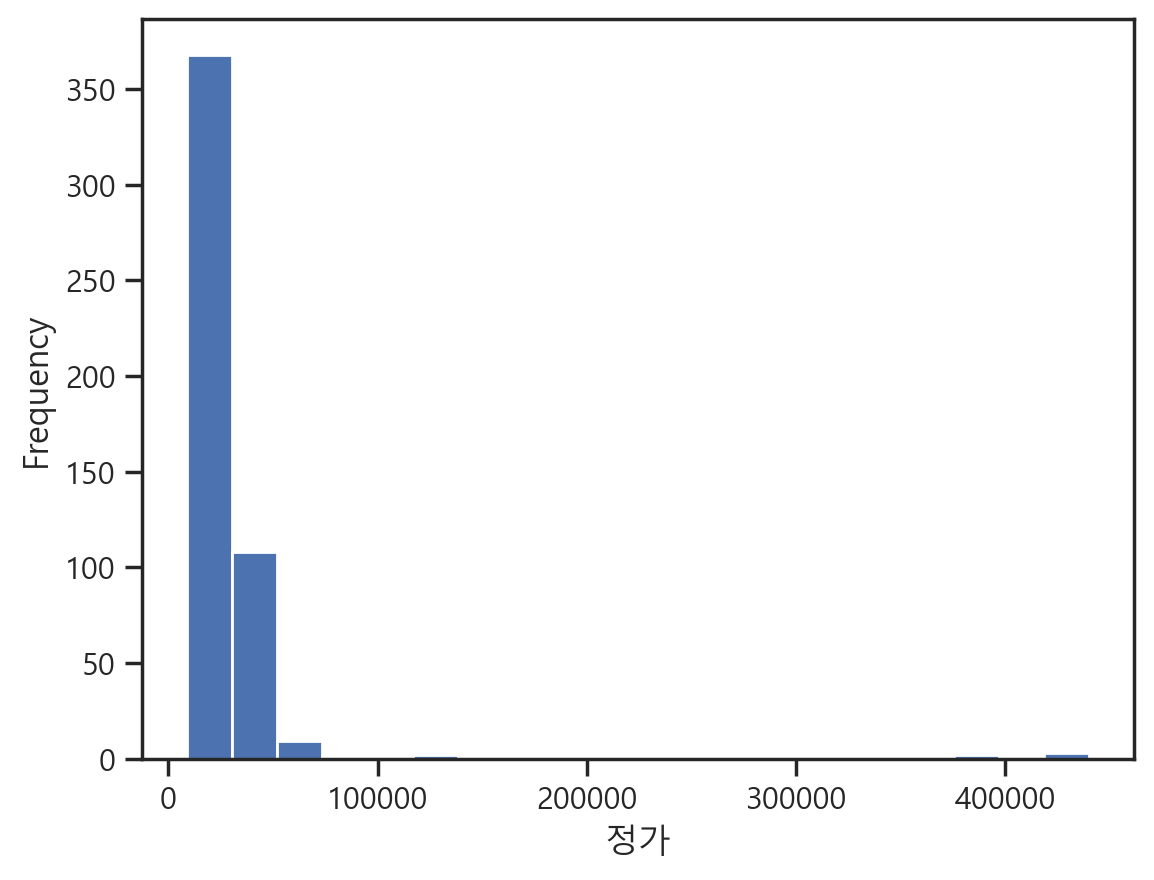

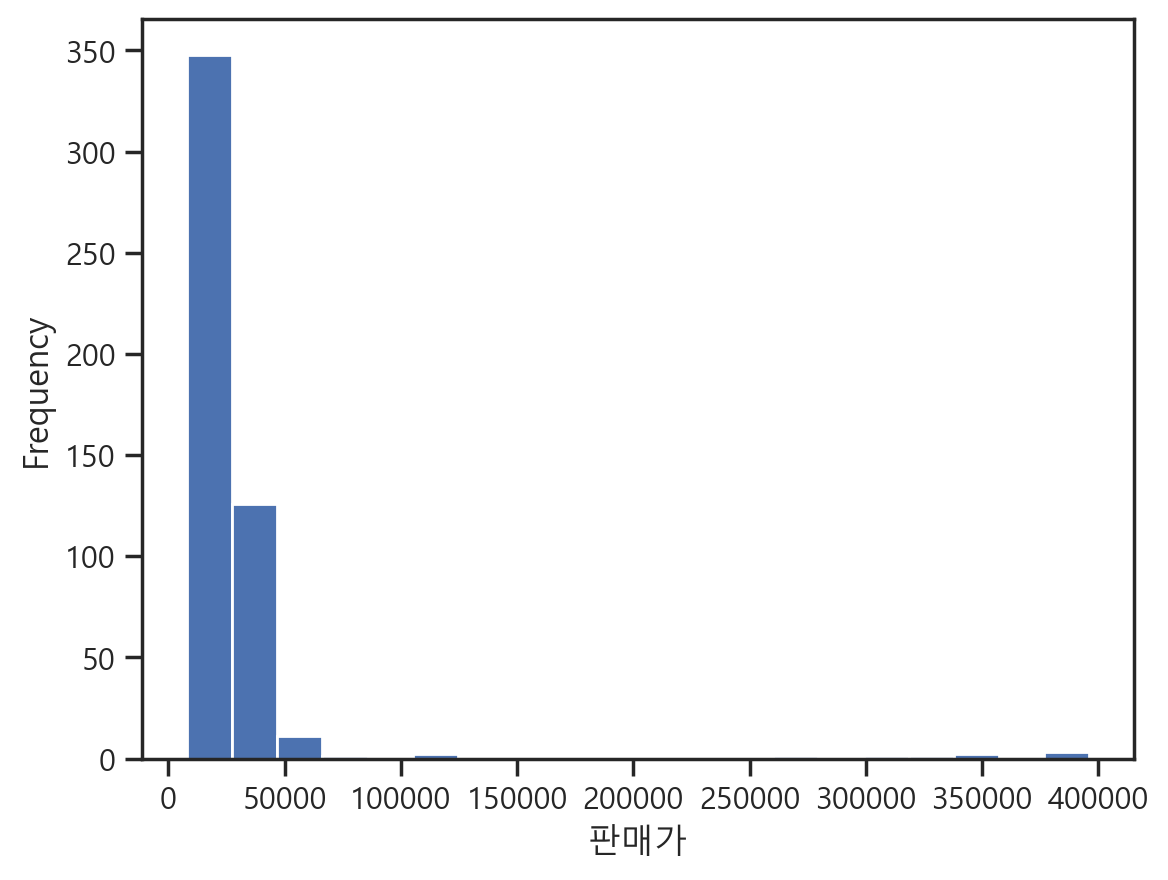

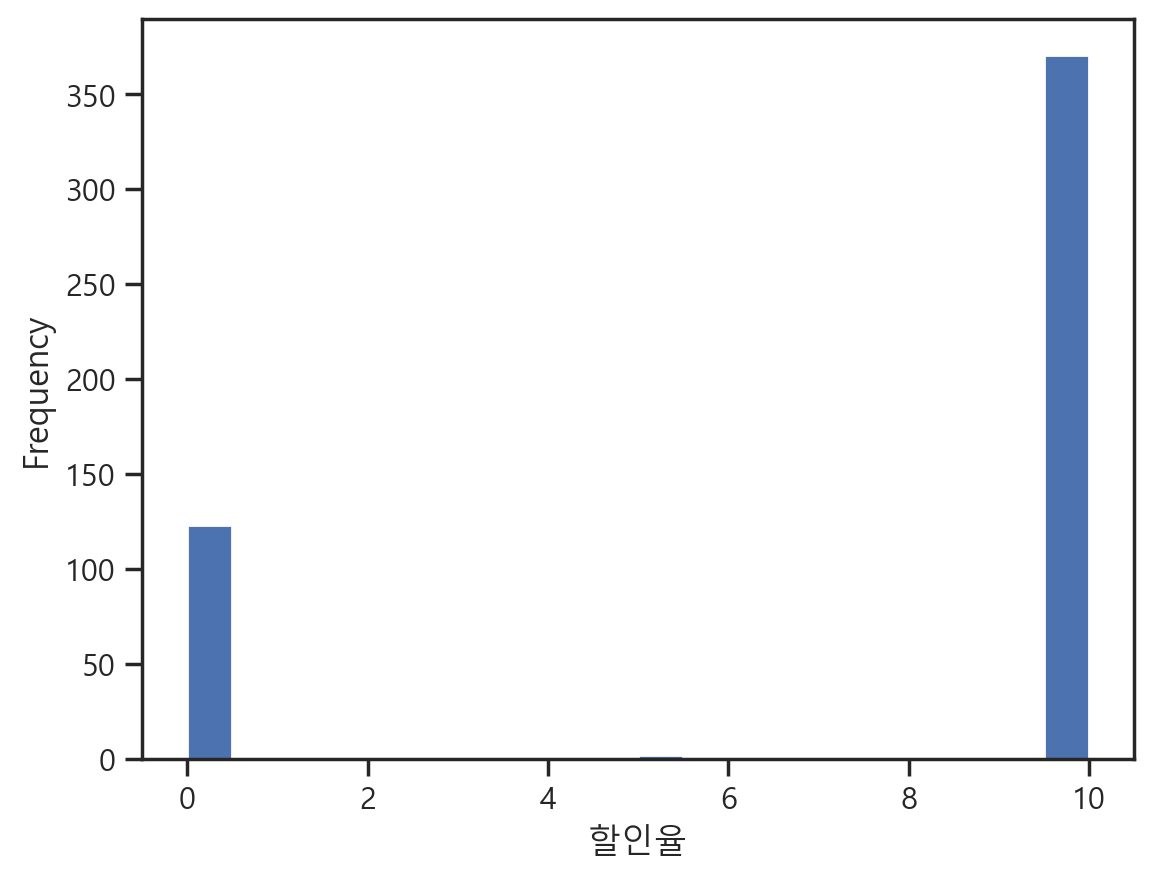

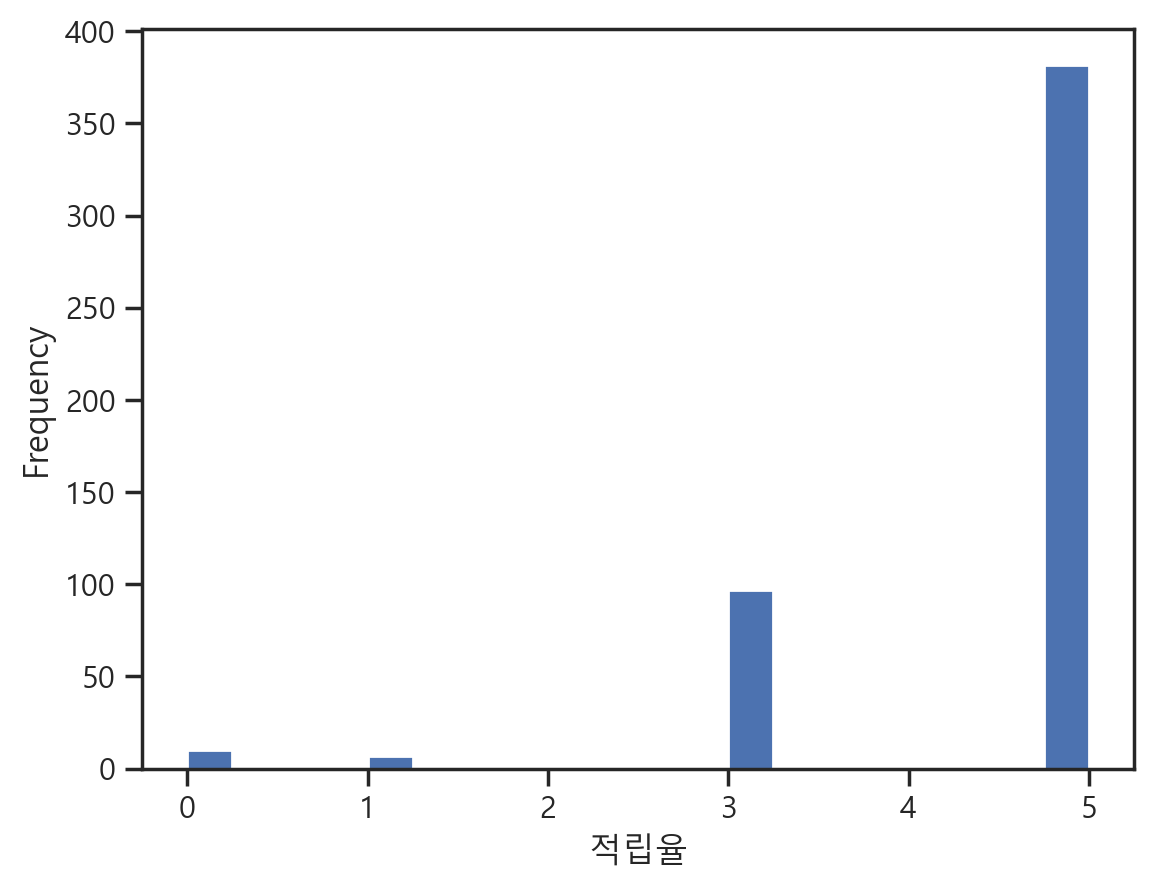

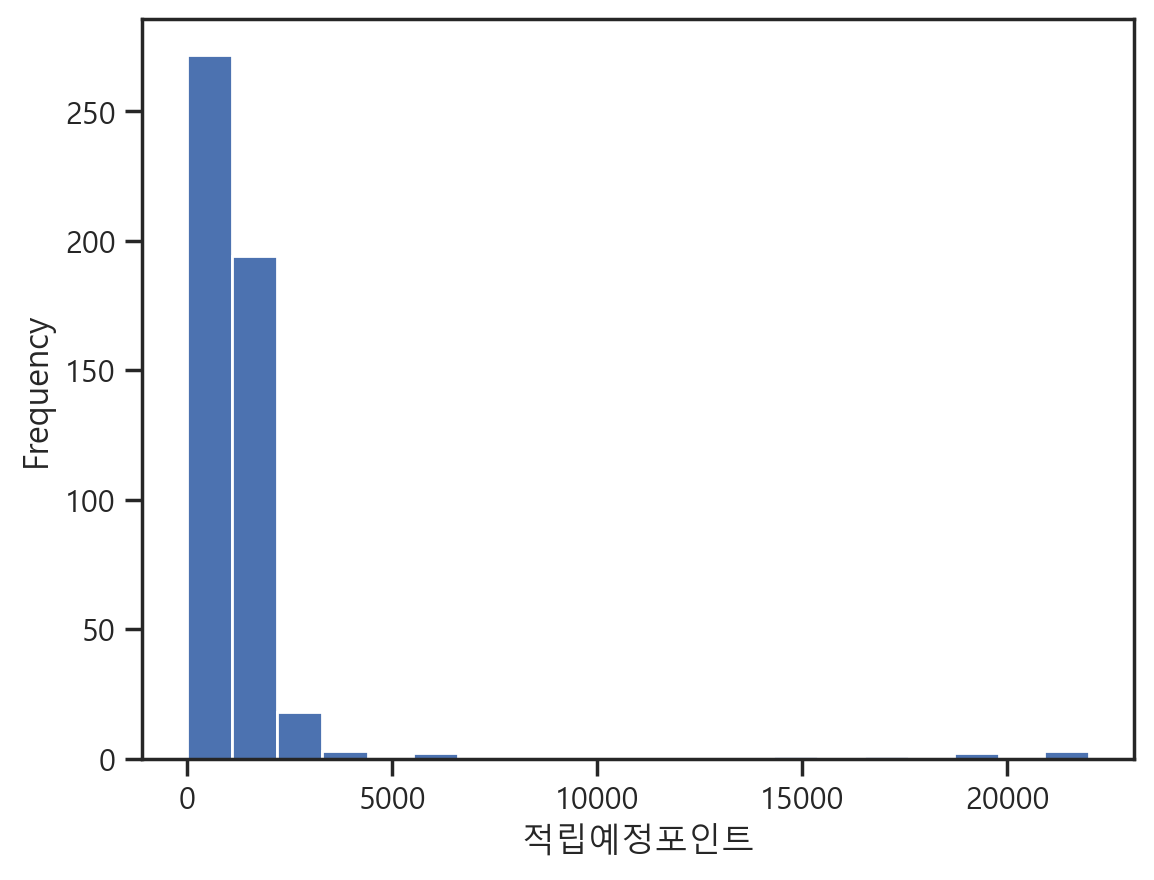

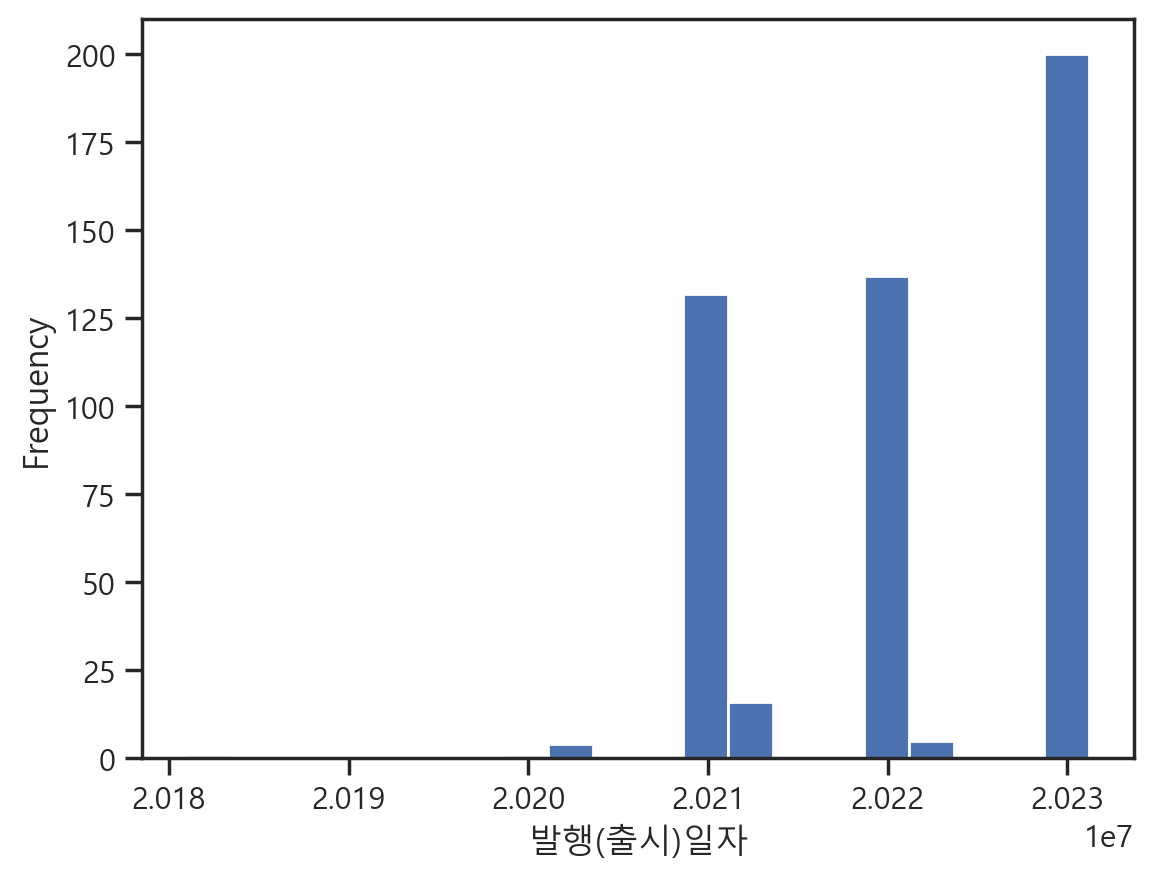

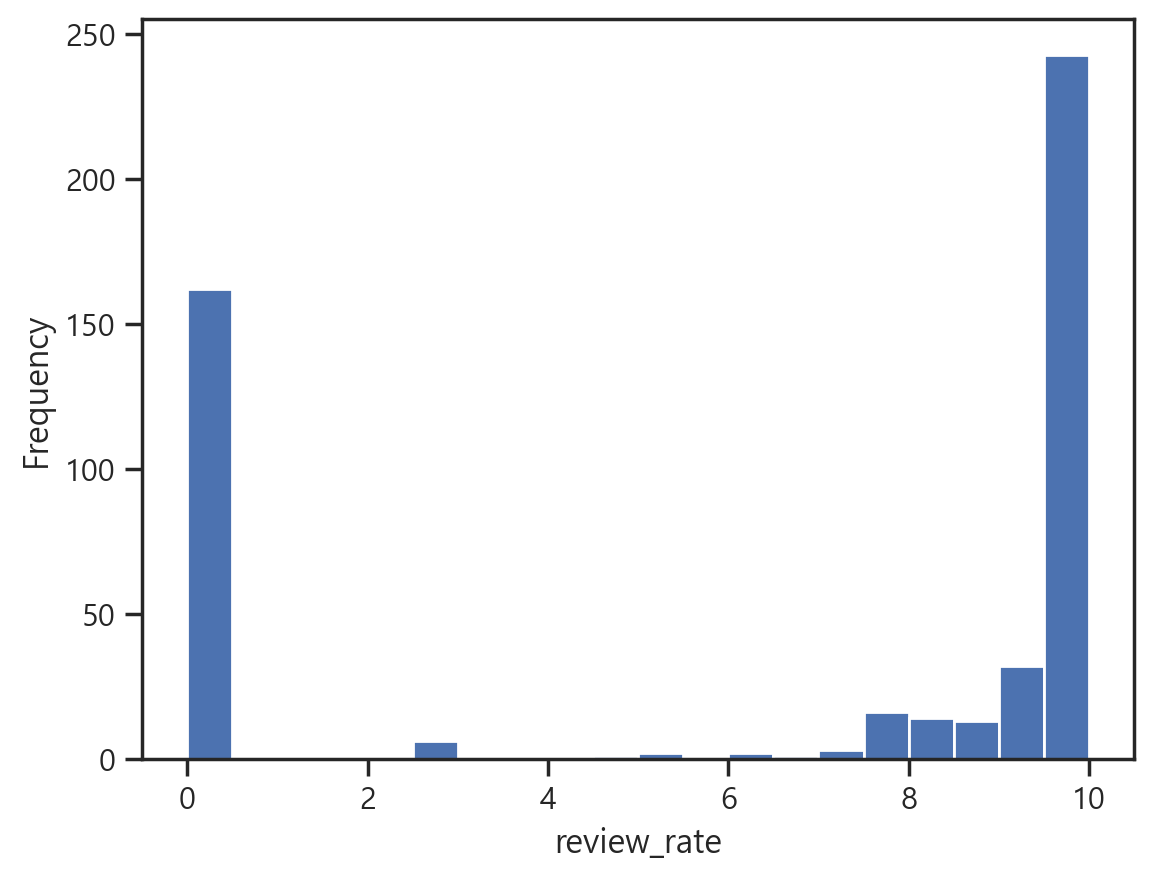

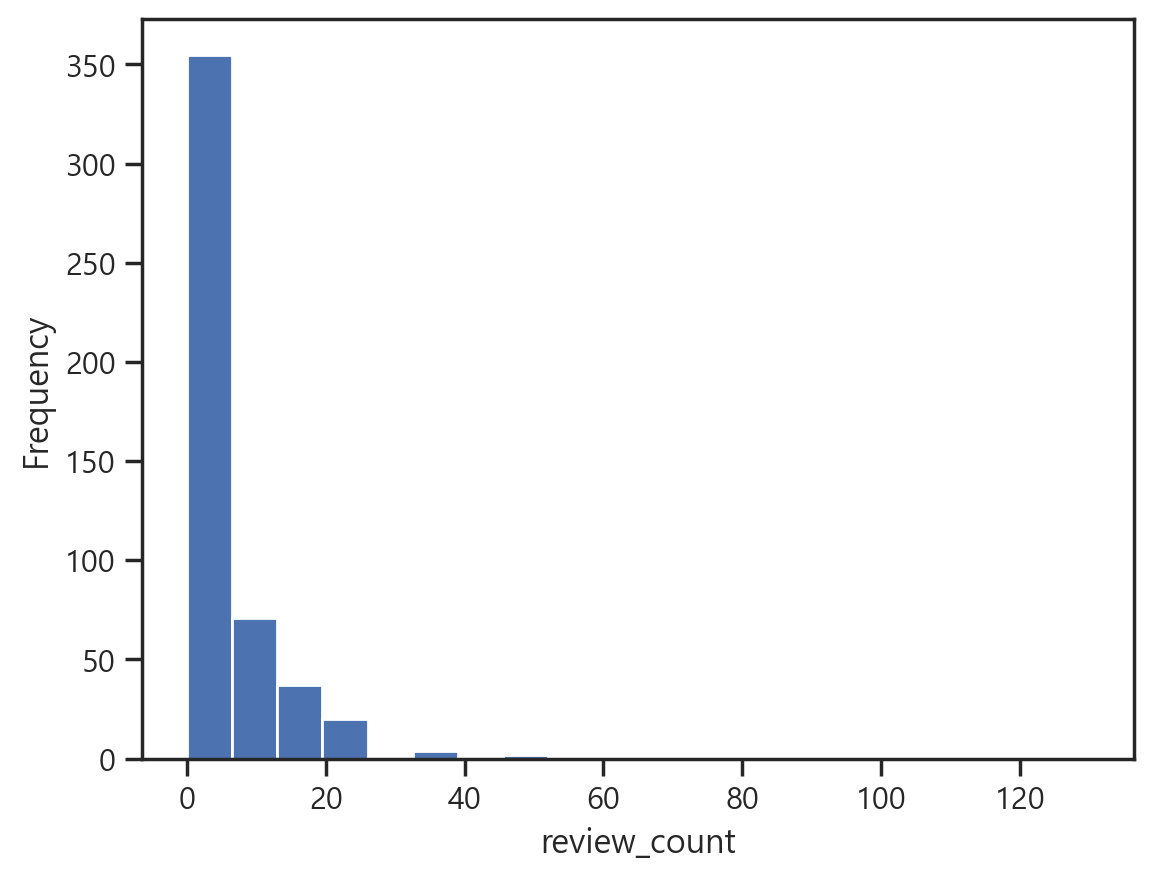

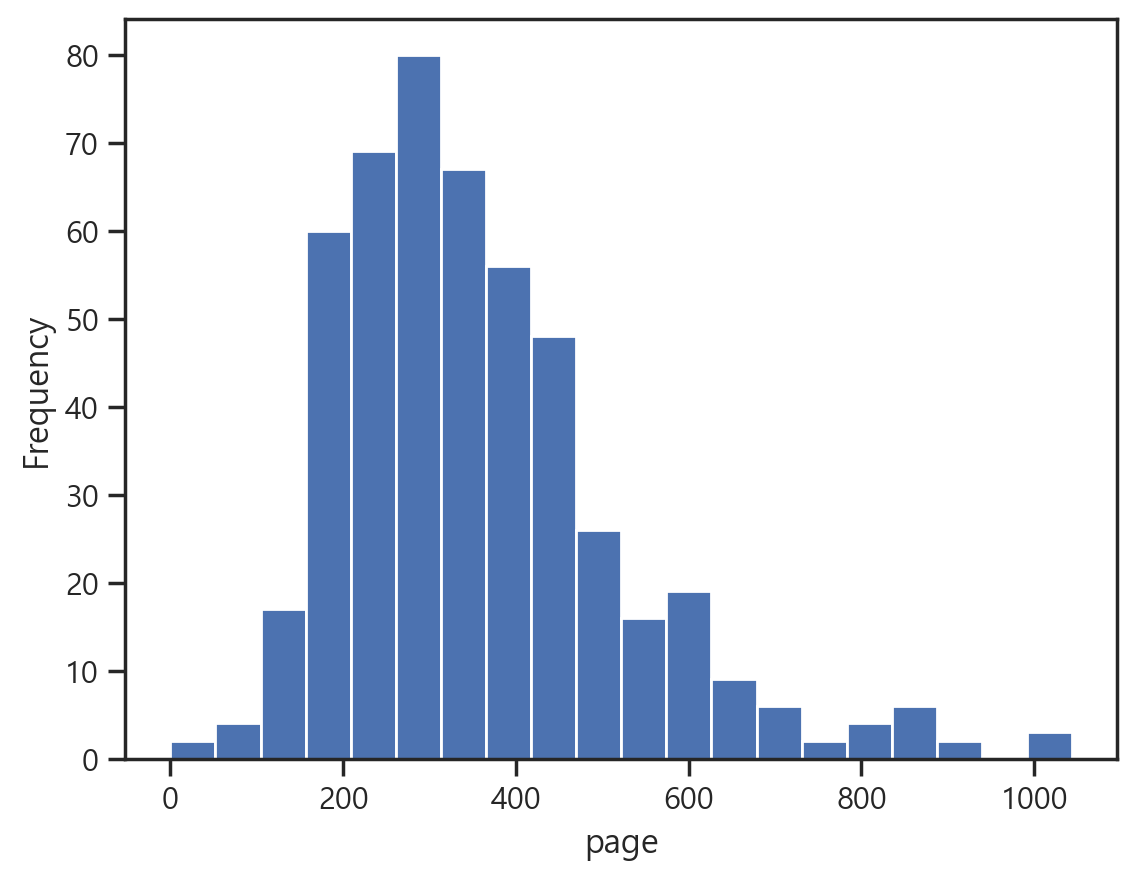

In [89]:
for i in range(0,len(cols)):
    hist(cols[i])

In [170]:
df_cor_temp = df_cor[['정가', '판매가', '할인율', '적립율', '적립예정포인트','review_rate',
       'review_count', 'page']]

In [172]:
df_cor_temp.describe() #요약통계(평균, 최소, 최대 값 등)

정가            판매가         할인율         적립율       적립예정포인트  \
count     496.000000     496.000000  496.000000  496.000000    496.000000   
mean    31783.669355   29248.407258    7.500000    4.451613   1418.770161   
std     47312.079260   42552.061993    4.322831    1.101733   2277.555818   
min      9000.000000    8100.000000    0.000000    0.000000      0.000000   
25%     18000.000000   17007.500000    5.000000    5.000000    820.000000   
50%     24000.000000   22500.000000   10.000000    5.000000   1000.000000   
75%     32000.000000   29000.000000   10.000000    5.000000   1442.500000   
max    440000.000000  396000.000000   10.000000    5.000000  22000.000000   

       review_rate  review_count         page  
count   495.000000    495.000000   496.000000  
mean      6.320202      5.834343   356.955645  
std       4.535719     10.759650   163.000657  
min       0.000000      0.000000     0.000000  
25%       0.000000      0.000000   244.000000  
50%       9.400000      2.000000   328.000000  
75%      10.000000      7.000000   432.000000  
max      10.000000    130.000000  1044.000000

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

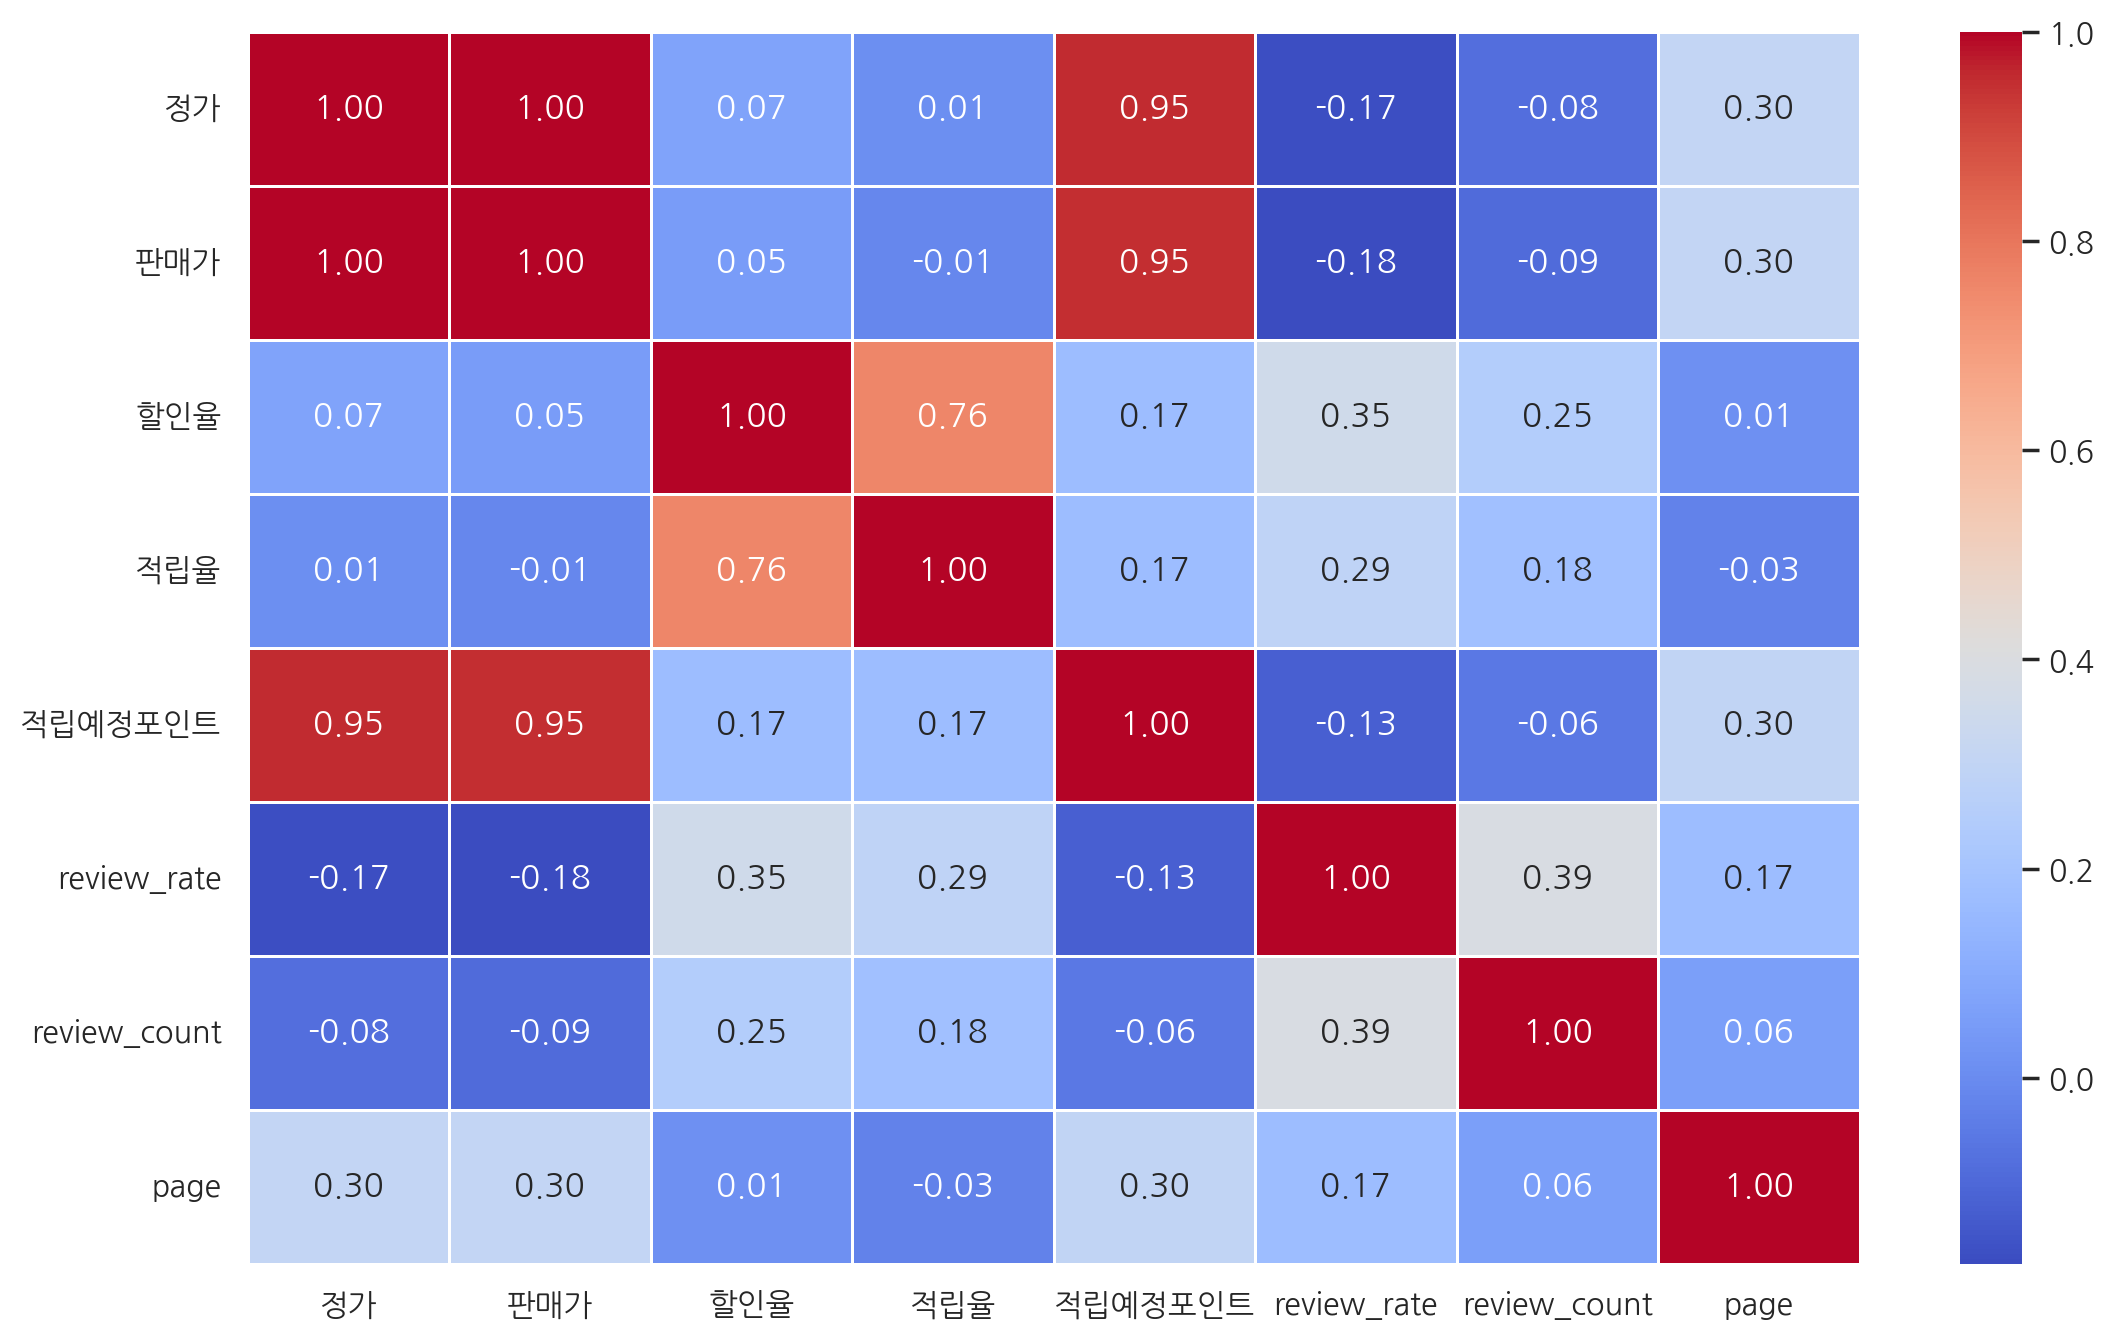

In [176]:
corr = df_cor_temp.corr()
plt.figure(figsize=(13, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('')
plt.show()

혹여 page 수가 많으면 review 수가 적다거나 하는 상관관계가 있을까 해서 시각화했는데 그렇게 의미있는 상관계수는 없는 것 같아요!

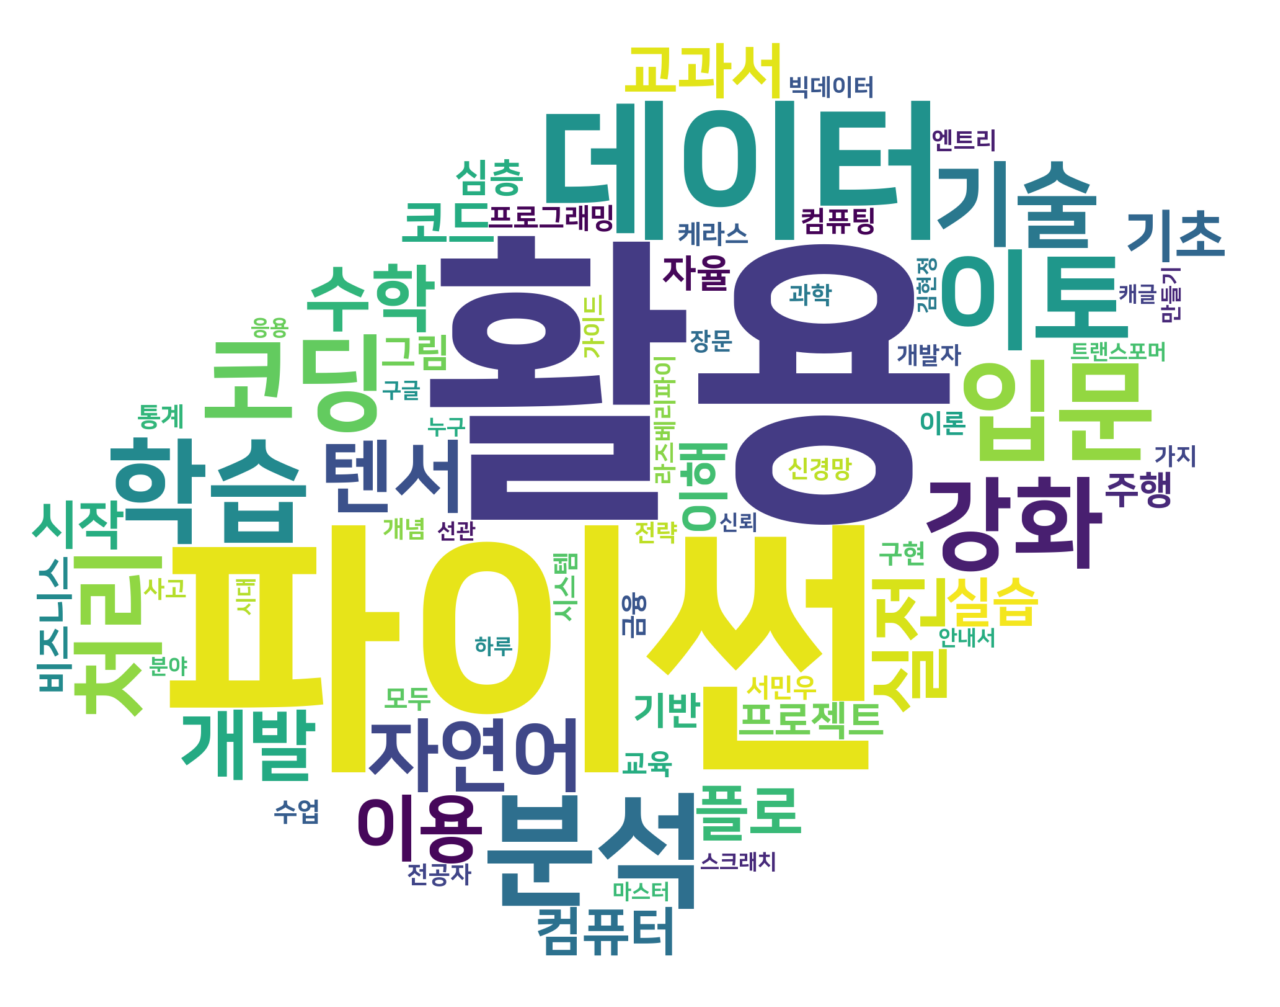

In [99]:
# 컴퓨터/IT 분야의 제목
word(df_com,'title')

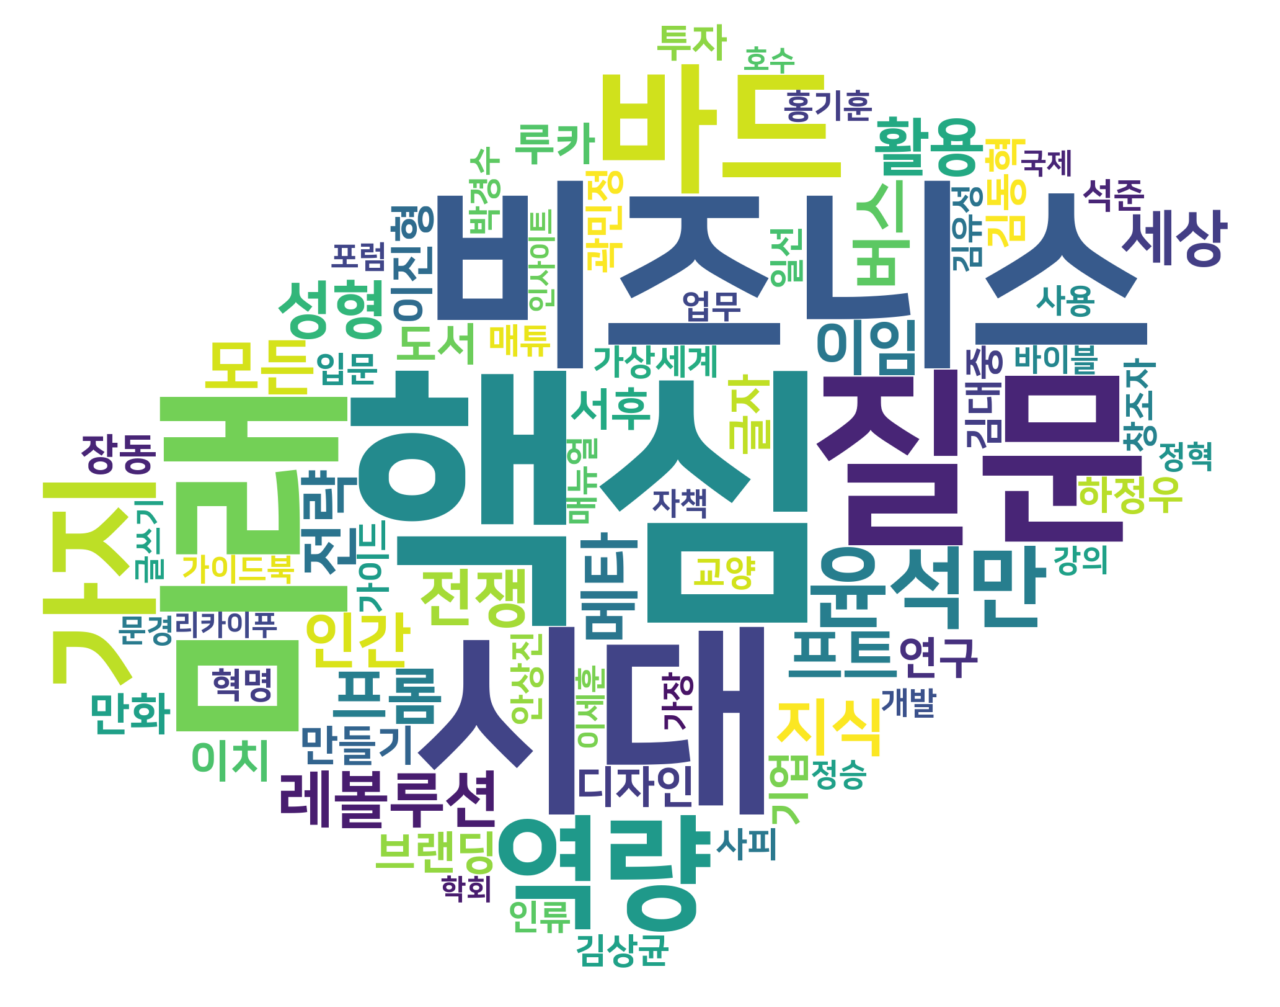

In [100]:
#경제/경영 분야 제목
word(df_manage,'title')

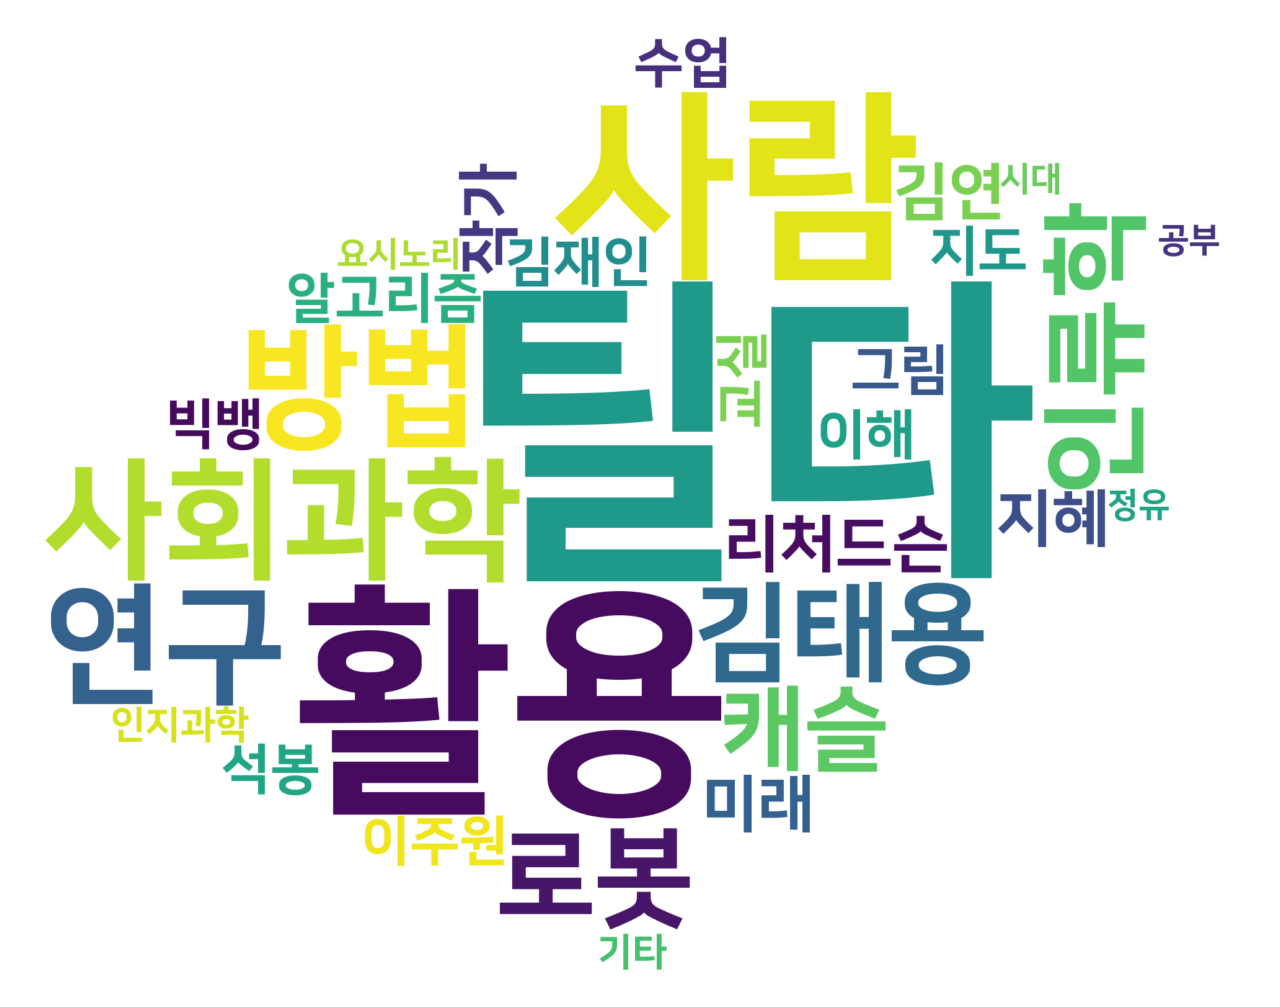

In [80]:
# 인문분야 제목
df_hu = df_temp[df_temp['분야']=='인문']
word(df_hu,'title')

In [121]:
df_hu

분야                                title  \
52   인문     인공지능을 활용한 사회과학 연구방법 | 김태용 - 교보문고   
56   인문        로봇과 AI의 인류학 | 캐슬린 리처드슨 - 교보문고   
64   인문    챗GPT 활용해 한달 만에 작가 되기 | 김연욱 - 교보문고   
90   인문      인공지능의 미래와 지혜의 알고리즘 | 석봉래 - 교보문고   
124  인문                   AI 빅뱅 | 김재인 - 교보문고   
141  인문    챗GPT 교실 수업을 위한 지도와 칼 | 이주원 - 교보문고   
273  인문  틸다(TILDA) 2 | 틸다 그리고 함께한 사람들 - 교보문고   
274  인문  틸다(TILDA) 1 | 틸다 그리고 함께한 사람들 - 교보문고   
309  인문    그림으로 이해하는 인지과학 | 기타하라 요시노리 - 교보문고   
324  인문              AI 시대의 공부법 | 정유남 - 교보문고   

                                                 index  \
52   머리말제1부 들어가며제2부 주요 애플리케이션 소개01 ChatGPT/GPT-402 ...   
56   감사의 말ㆍ7머리말: 절멸불안과 기계ㆍ11\t인류여, 너희의 종말을 경계하라ㆍ16 ...   
64   프롤로그\tChapter 1: 글쓰기와 인공지능\t1. 챗GPT 등장과 글쓰기\t인...   
90   서문1장. 인공지능과 자연지능: 지능을 가진 기계와 지혜로운 기계 2장. 컴퓨터와 ...   
124  추천의 글 ㆍ004프롤로그: 생성 인공지능이 제기하는 문제들 ㆍ 0161부  생성 ...   
141  프롤로그 챗GPT라는 거인의 어깨 위에서 세상을 보기 1장 챗GPT 교실 수업에서 ...   
273  2022년● 1월● 2월● 3월● 4월● 5월● 6월● 7월● 8월● 9월● 10월...   
274  1. TRACES OF TILDATilda's Google Search Histor...   
309  1장 인지과학 개론  __1.1 인지과학  __1.2 인지과학이 걸어온 길  __1...   
324  프롤로그1장. 디지털 네이티브를 위한 공부란?\t    1. 디지털 네이티브 학생과...   

                                             book_info  \
52   ChatGPT와 그것의 상위 버전 GPT-4가 파란을 일으키고 있다. 8월 24일에...   
56   MIT 로봇학 실험실을 직접 현장 조사하여 일구어낸 로봇과 로봇학자들의 숨은 진짜 ...   
64   이 도서는 작가가 되고자 하는 모든 이들, 기업, 교육기관, 크리에이티브 전문가를 ...   
90   주어진 프로그램을 빠르게 처리하는 기계라는 측면에서 보면, 인공지능의 정신성과 자유...   
124  2023년 3월 챗GPT-4의 등장으로 AI 발전 전망을 둘러싼 논쟁이 뜨겁다. 인...   
141  챗GPT를 제대로 활용하는 방법의 핵심은 ‘효과적으로 질문하는 법’에 있다. 이 책...   
273  세계 최초 인공지능 휴먼 브랜딩 책이 나왔다. AI 아티스트 틸다가 그 주인공이다....   
274  세계 최초 인공지능 휴먼 브랜딩 책이 나왔다. AI 아티스트 틸다가 그 주인공이다....   
309  저자는 정보행동과학을 전공하며 인지심리학, 행동과학실험, 수리언어학, 컴퓨터과학 등...   
324  이 책은 학계와 교육계에 몸담고 있었던 경험과 노하우를 AI 시대의 공부법으로 소개...   

                                           author_info  \
52   ['저자는 ‘AI를 장착한 인간’이라고 스스로를 칭한다. 경희대학교 미디어학과 교수...   
56   ['(Kathleen Richardson)케임브리지대학교 사회인류학과에서 MIT 로...   
64   ['저자는 글쓰기와 관련해 광범위한 연구와 강의 경험을 갖춘 글쓰기 분야의 전문가로...   
90   ['(Bongrae Seok)서울대학교 철학과를 졸업하고 미국 애리조나대학교에서 박...   
124  ['철학자. 경희대학교 비교문화연구소 학술연구교수. 포스텍 융합문명연구원 《웹진X》...   
141  ['교직을 자기계발의 플랫폼으로 활용하여 학생들과 함께 성장 중인 20년 차 교사....   
273  ['틸다는 ~ (물결표) 을 뜻하는 이름을 가진 AI 아티스트 입니다. 더 나은 세...   
274  ['틸다는 ~ (물결표) 을 뜻하는 이름을 가진 AI 아티스트 입니다. 더 나은 세...   
309  ['1955년 시즈오카현 출생. 1979년 히로시마대학 종합과학부 정보행동과학 과정...   
324  ['鄭有男현재 중앙대학교인문콘텐츠연구소 HK연구교수로 재직하며, 중앙대, 고려대에서...   

                                           review_text  
52   \n이미 인공지능을 좀 알고 구입해서 완전 새롭진 않았지만 그래도 사회과학 분야에 ...  
56                                                 NaN  
64   \n제목과 달리 Chat GPT로 글을 쓰는데 별로 도움되지 않는 내용입니다.구입한...  
90                                   \n잘 받았습니다. 감사합니다!  
124  \n예술 작품은 대체될 수 있을까 (아니, 예술가는 대체될 수 있을까)그 답을 위해...  
141  \n보고 싶던 책입니다.\n'챗GPT 교실 수업을 위한 지도와 칼'은 20년차 교사...  
273                                                NaN  
274                                                NaN  
309  \n외부의 자극을 주의 집중을 통해 감각기관이 받아 들이고 그 중 일부는 지식이라는...  
324                                                NaN